# RATE MY PROFESSOR DATA ANALYSIS - FINN F.

### For explantation of the reasoning and results of each problem, please refer to the Project_PDF in the repository

## Imports and Data Preparation

##### IMPORTS

In [207]:
import math
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy.stats import (
    mannwhitneyu,
    ks_2samp, 
    kruskal,
    spearmanr
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    LogisticRegression
)
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    mean_squared_error,
    r2_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

import scikit_posthocs as sp

##### DATA PREPERATION

In [208]:
n_number = 12355911
np.random.seed(n_number)

# Storing both csvs into a single dataframe
num_df = pd.read_csv('rmpCapstoneNum.csv', names=[
    'average_rating', 
    'average_difficulty', 
    'num_ratings', 
    'recieved_pepper', 
    'retake_perc', 
    'num_online_ratings', 
    'is_confirmed_male', 
    'is_confirmed_female'
], header=None)

qual_df = pd.read_csv('rmpCapstoneQual.csv', names=['field', 'university', 'state'], header=None)

df = pd.concat([num_df, qual_df], axis=1)


# Defining the stability of a professor's average rating based on the number of ratings they have recieved
# Function to calculate the minimum number of ratings a professor needs for their average rating to stay within a given threshold given a new extreme rating
def stable_ratings_count(threshold, current_avg = 5.0, new_rating=1.0):
    n = 1  
    while True:
        new_avg = (current_avg * n + new_rating) / (n + 1)   
        change= abs(new_avg - current_avg)   
        if change <= threshold:
            return n
        n += 1


high_stability_threshold = stable_ratings_count(0.3)
medium_stability_threshold = stable_ratings_count(0.7)
low_stability_threshold = stable_ratings_count(1.0)
severely_low_stability_threshold = 1

print(f"Number of ratings needed for a low_stability_threshold average rating: {low_stability_threshold}")
print(f"Number of ratings needed for a medium_stability_threshold average rating: {medium_stability_threshold}")
print(f"Number of ratings needed for a high_stability_threshold average rating: {high_stability_threshold}")
print(f"Number of ratings needed for a severely_low_stability_threshold average rating: {severely_low_stability_threshold}")

Number of ratings needed for a low_stability_threshold average rating: 3
Number of ratings needed for a medium_stability_threshold average rating: 5
Number of ratings needed for a high_stability_threshold average rating: 13
Number of ratings needed for a severely_low_stability_threshold average rating: 1


## Problem 1: Gender Bias

##### Data Preparation and Exploration (problem 1)

Number of professors with confirmed gender: 54302
Number of rows with confirmed gender: 54302


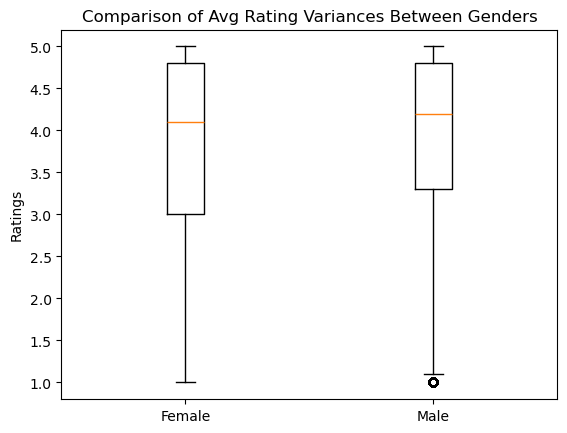

Variance Female: 1.305212939167971
Variance Male: 1.183956715477674
Variance Ratio: 1.1024160952044395


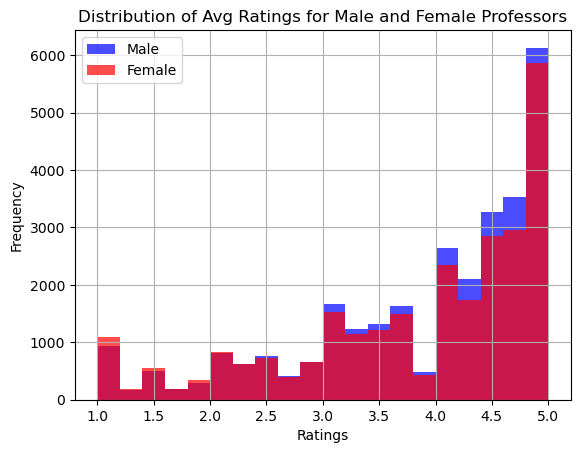

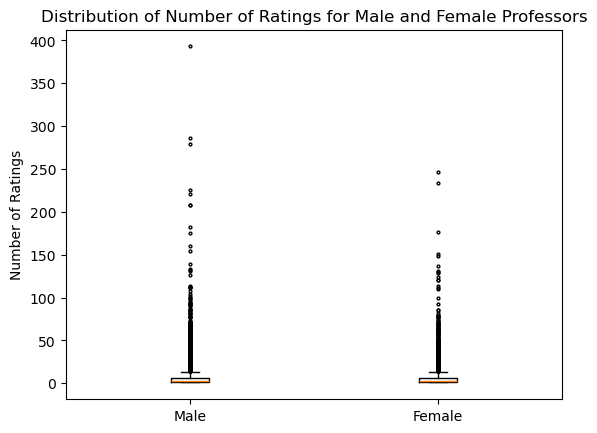

In [209]:
# PHASE 1: DATA PREPARATION AND EXPLORATION

# ----------------------------
# Step 1: Data Preparation
# ----------------------------

prob1_data = df.copy()

# Define gender: 0 = Male, 1 = Female, exclude -1 (not confirmed)
prob1_data['gender'] = -1  
prob1_data.loc[prob1_data['is_confirmed_male'] == 1, 'gender'] = 0
prob1_data.loc[prob1_data['is_confirmed_female'] == 1, 'gender'] = 1  
prob1_data = prob1_data[prob1_data['gender'] != -1]

# Create a 'gender_label' column for better readability in visualizations
prob1_data['gender_label'] = prob1_data['gender'].map({0: 'Male', 1: 'Female'})

# Check for missing values and drop rows with missing 'average_rating', 'num_ratings', or 'gender'
prob1_data = prob1_data.dropna(subset=['average_rating', 'num_ratings', 'gender'])

print("Number of professors with confirmed gender:", len(prob1_data))

# ----------------------------
# Step 2: Data Exploration
# ----------------------------

# df with rows where gender is confirmed
confirmed_gender = df[(df['is_confirmed_male'] == 1) | (df['is_confirmed_female'] == 1)]
print("Number of rows with confirmed gender:", confirmed_gender.shape[0])

# Displaying the differnece of variance between male and female ratings
female_ratings = df[df['is_confirmed_female'] == 1]['average_rating']
male_ratings = df[df['is_confirmed_male'] == 1]['average_rating']
plt.boxplot([female_ratings, male_ratings], labels=['Female', 'Male'])
plt.title('Comparison of Avg Rating Variances Between Genders')
plt.ylabel('Ratings')
plt.show()

# Calculating the ratio of variance between male and female ratings
female_ratings = df[df['is_confirmed_female'] == 1]['average_rating']
male_ratings = df[df['is_confirmed_male'] == 1]['average_rating']
variance_female = female_ratings.var()
variance_male = male_ratings.var()
variance_ratio = max(variance_female, variance_male) / min(variance_female, variance_male)
print('Variance Female:', variance_female)
print('Variance Male:', variance_male)
print('Variance Ratio:', variance_ratio)

# Plotting the distribution of average ratings for male and female professors
plt.hist(male_ratings, bins=20, color='blue', alpha=0.7, label='Male')
plt.hist(female_ratings, bins=20, color='red', alpha=0.7, label='Female')
plt.title('Distribution of Avg Ratings for Male and Female Professors')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
num_ratings_male = df[df['is_confirmed_male'] == 1]['num_ratings']
num_ratings_female = df[df['is_confirmed_female'] == 1]['num_ratings']
plt.boxplot([num_ratings_male, num_ratings_female], labels=['Male', 'Female'], flierprops=dict(marker='o', markersize=2))
plt.title('Distribution of Number of Ratings for Male and Female Professors')
plt.ylabel('Number of Ratings')
plt.show()


##### Solution (problem 1)

In [210]:
# ----------------------------
# Step 1: Stratifying Data to account for num_ratings
# ----------------------------

# Assign stability based on the num_ratings column
prob1_data['rating_stability'] = pd.cut(prob1_data['num_ratings'], 
                                   bins=[0, low_stability_threshold, medium_stability_threshold, high_stability_threshold, float('inf')], 
                                   labels=['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability'],
                                   right=False)



# ----------------------------
# Step 2: Significance Testing and Effect Size Calculation using Kolmogorov-Smirnov Test
# ----------------------------


# Initialize an empty dictionary to store results
results = {}

# Iterate over each stability category including 'severely_low_stability'
for stability in ['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability']:
    # Subset the data based on stability category
    subset = prob1_data[prob1_data['rating_stability'] == stability]
    males = subset[subset['gender_label'] == 'Male']['average_rating']
    females = subset[subset['gender_label'] == 'Female']['average_rating']
    
    # Perform the Mann-Whitney U test
    u_stat, p_value = scipy.stats.mannwhitneyu(males, females, alternative='two-sided')
    
    # Calculate rank-biserial correlation as effect size
    m = len(males)
    n = len(females)
    rank_biserial = 1 - (2 * u_stat) / (m * n)
    
    # Store the results in the dictionary
    results[stability] = {
        'U_statistic': u_stat,
        'p_value': p_value,
        'rank_biserial_correlation': rank_biserial
    }

# Convert the results dictionary to a DataFrame for easier interpretation
results_df = pd.DataFrame(results).T
print("Mann-Whitney U Test and Rank-Biserial Correlation Results:")
print(results_df)

Mann-Whitney U Test and Rank-Biserial Correlation Results:
                        U_statistic   p_value  rank_biserial_correlation
severely_low_stability   69245969.5  0.026011                  -0.016516
low_stability            17652456.5  0.030950                  -0.022931
medium_stability         26980429.0  0.020193                  -0.022231
high_stability            2813550.5  0.007510                  -0.045359


##### Visualizing Findings (problem 1)

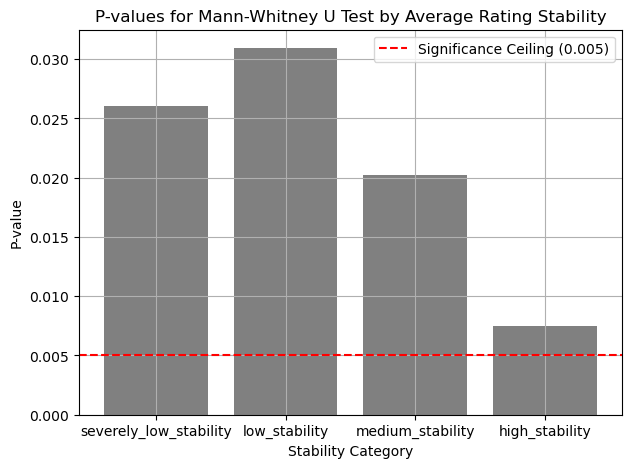

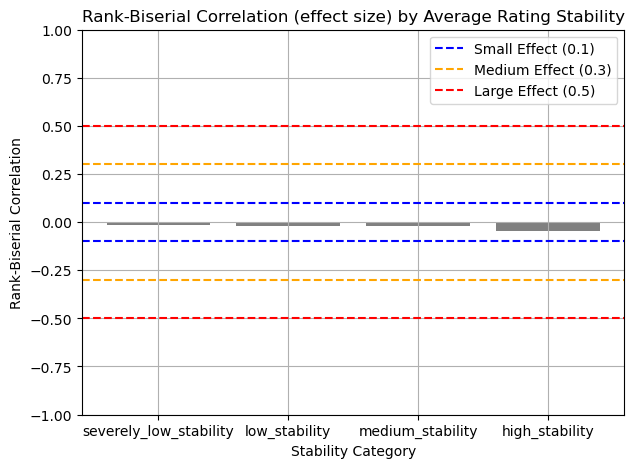

In [211]:
# Plotting p-values with significance ceiling
plt.figure(figsize=(7, 5))
plt.bar(results_df.index, results_df['p_value'], color='grey')
plt.axhline(y=0.005, color='red', linestyle='--', label='Significance Ceiling (0.005)')
plt.title('P-values for Mann-Whitney U Test by Average Rating Stability')
plt.xlabel('Stability Category')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting rank-biserial correlation values with adjusted y-axis limits and effect size lines
plt.figure(figsize=(7, 5))
plt.bar(results_df.index, results_df['rank_biserial_correlation'], color='grey')
plt.title('Rank-Biserial Correlation (effect size) by Average Rating Stability')
plt.xlabel('Stability Category')
plt.ylabel('Rank-Biserial Correlation')
plt.ylim(-1, 1)  # Set y-axis limits from -1 to 1

# Adding lines for effect sizes
plt.axhline(y=0.1, color='blue', linestyle='--', label='Small Effect (0.1)')
plt.axhline(y=-0.1, color='blue', linestyle='--')
plt.axhline(y=0.3, color='orange', linestyle='--', label='Medium Effect (0.3)')
plt.axhline(y=-0.3, color='orange', linestyle='--')
plt.axhline(y=0.5, color='red', linestyle='--', label='Large Effect (0.5)')
plt.axhline(y=-0.5, color='red', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()

## Problem 2: Experience Level Effect on Average Rating

##### Data Preparation and Exploration (problem 2)

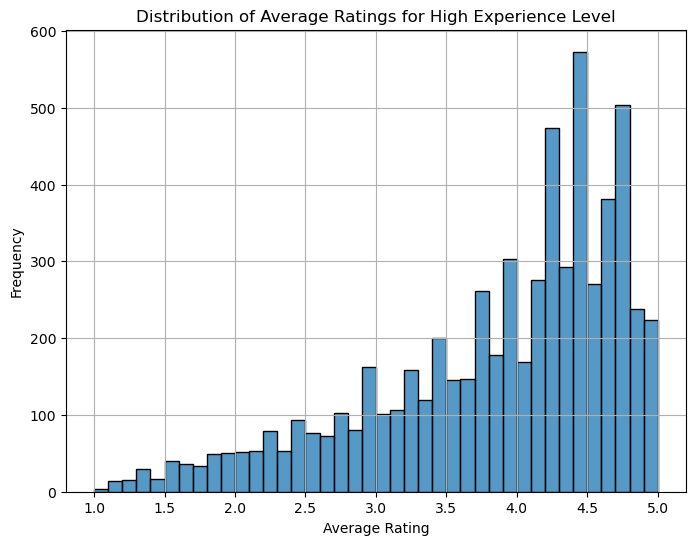

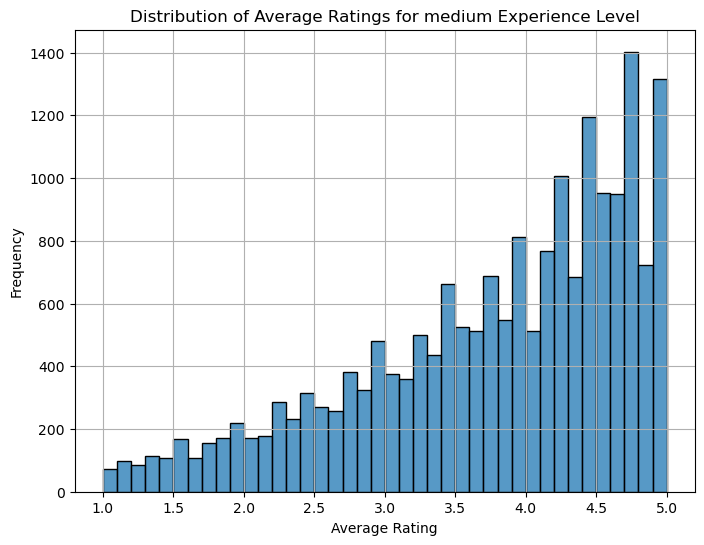

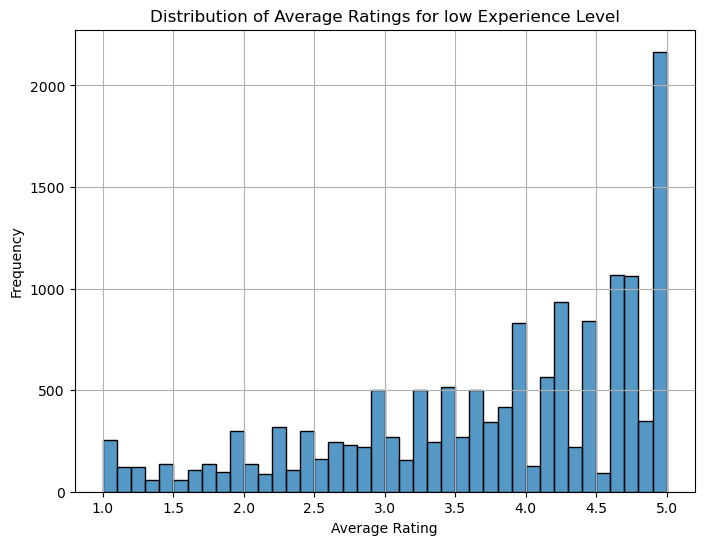

rating_group
5-10     30687
11-16     5696
17-22     2106
29+       1152
23-28      887
Name: count, dtype: int64


/var/folders/22/nj5n1yc16qg46gjfc5b_npsm0000gn/T/ipykernel_47734/3608464698.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating_group', y='average_rating', data=prob2_data, palette="Set3")


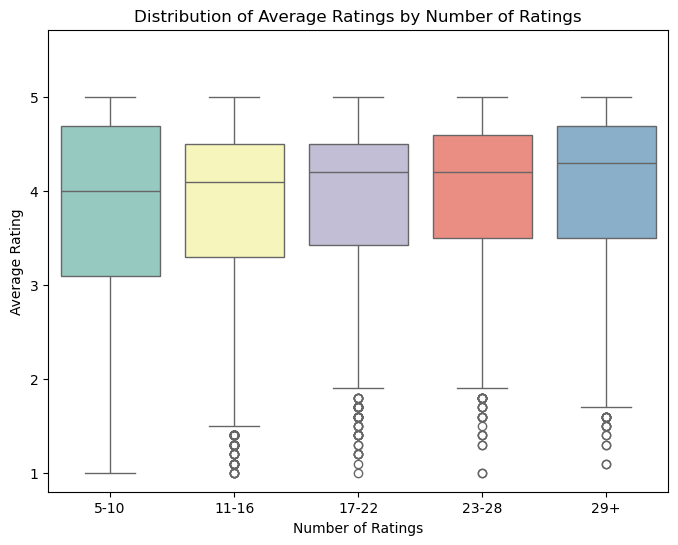

In [212]:
# ----------------------------
# Step 1: Data Preparation
# ----------------------------

prob2_data = df.copy()
# Define thresholds for "rating_stability" based on "average_rating"
prob2_data['experience_level'] = pd.cut(prob2_data['num_ratings'],
                                        bins=[0, 2, 4, 12, float('inf')],
                                        labels=['severely_low', 'low', 'medium', 'high'])

prob2_data.dropna(subset=['num_ratings', 'average_rating'], inplace=True)
prob2_data = prob2_data[prob2_data['experience_level'] != 'severely_low']

# ----------------------------
# Step 2: Data Exploration
# ----------------------------

high_experience_data = prob2_data[prob2_data['experience_level'] == 'high']
plt.figure(figsize=(8, 6))
sns.histplot(high_experience_data['average_rating'], bins=np.arange(1.0, 5.1, 0.1))
plt.title('Distribution of Average Ratings for High Experience Level')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

high_experience_data = prob2_data[prob2_data['experience_level'] == 'medium']
plt.figure(figsize=(8, 6))
sns.histplot(high_experience_data['average_rating'], bins=np.arange(1.0, 5.1, 0.1))
plt.title('Distribution of Average Ratings for medium Experience Level')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


high_experience_data = prob2_data[prob2_data['experience_level'] == 'low']
plt.figure(figsize=(8, 6))
sns.histplot(high_experience_data['average_rating'], bins=np.arange(1.0, 5.1, 0.1))
plt.title('Distribution of Average Ratings for low Experience Level')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



# Redesigned plot to enhance visual clarity and adjust y-axis spacing based on number of ratings
fig, ax = plt.subplots(figsize=(8, 6))
# Create a new column 'rating_group' to categorize the number of ratings
prob2_data['rating_group'] = pd.cut(prob2_data['num_ratings'], bins=[0, 10, 16, 22, 28, float('inf')], labels=['5-10', '11-16', '17-22', '23-28', '29+'], right=False)
print(prob2_data['rating_group'].value_counts())
sns.boxplot(x='rating_group', y='average_rating', data=prob2_data, palette="Set3")
ax.set_title('Distribution of Average Ratings by Number of Ratings')
ax.set_xlabel('Number of Ratings')
ax.set_ylabel('Average Rating')
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max * 1.1)
plt.show()

##### Solution (problem 2)

In [213]:
# ----------------------------
# Step 1: Significance Testing and Effect Size Calculation using Kruskal-Wallis Test
# ----------------------------


# Extracting data for each experience level
data_low = prob2_data[prob2_data['experience_level'] == 'low']['average_rating']
data_medium = prob2_data[prob2_data['experience_level'] == 'medium']['average_rating']
data_high = prob2_data[prob2_data['experience_level'] == 'high']['average_rating']

# Performing Kruskal-Wallis Test
kruskal_result = kruskal(data_low, data_medium, data_high)
print("Kruskal-Wallis Test Result:", kruskal_result)


# Check if the Kruskal-Wallis test was significant before performing Dunn's Test
if kruskal_result.pvalue < 0.005:
    print("Significant differences found. Proceeding with Dunn's Test for pairwise comparisons.")

    # Perform Dunn's Test for multiple comparisons
    dunn_results = sp.posthoc_dunn(prob2_data, val_col='average_rating', group_col='experience_level', p_adjust='bonferroni')

    # Print the results of Dunn's Test
    print("Dunn's Test Pairwise Comparisons (Bonferroni corrected p-values):")
    print(dunn_results)

#--------------------------------
# Step 2: Doing a Mann-Whitney U Test and Bisereal Correlation between significant groups to examine effect size
#--------------------------------

# Extracting data for medium and high experience levels
data_medium = prob2_data[prob2_data['experience_level'] == 'medium']['average_rating']
data_high = prob2_data[prob2_data['experience_level'] == 'high']['average_rating']

# Performing Mann-Whitney U Test for medium and high experience levels
mann_whitney_result_medium_high = mannwhitneyu(data_medium, data_high, alternative='two-sided')

# Calculate rank-biserial correlation as effect size for medium and high
m_high = len(data_medium)
n_high = len(data_high)
rank_biserial_medium_high = 1 - (2 * mann_whitney_result_medium_high.statistic) / (m_high * n_high)
print('Rank-Biserial Correlation (Medium vs High):', rank_biserial_medium_high)

# Extracting data for medium and low experience levels
data_low = prob2_data[prob2_data['experience_level'] == 'low']['average_rating']

# Performing Mann-Whitney U Test for medium and low experience levels
mann_whitney_result_medium_low = mannwhitneyu(data_medium, data_low, alternative='two-sided')

# Calculate rank-biserial correlation as effect size for medium and low
m_low = len(data_medium)
n_low = len(data_low)
rank_biserial_medium_low = 1 - (2 * mann_whitney_result_medium_low.statistic) / (m_low * n_low)
print('Rank-Biserial Correlation (Medium vs Low):', rank_biserial_medium_low)

Kruskal-Wallis Test Result: KruskalResult(statistic=25.718654756867455, pvalue=2.6017470964348707e-06)
Significant differences found. Proceeding with Dunn's Test for pairwise comparisons.
Dunn's Test Pairwise Comparisons (Bonferroni corrected p-values):
             low    medium      high
low     1.000000  0.000359  0.422182
medium  0.000359  1.000000  0.000034
high    0.422182  0.000034  1.000000
Rank-Biserial Correlation (Medium vs High): 0.038367909410828904
Rank-Biserial Correlation (Medium vs Low): 0.023516682737951045


/opt/anaconda3/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/opt/anaconda3/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:374: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


##### Visualizing Findings (problem 2)

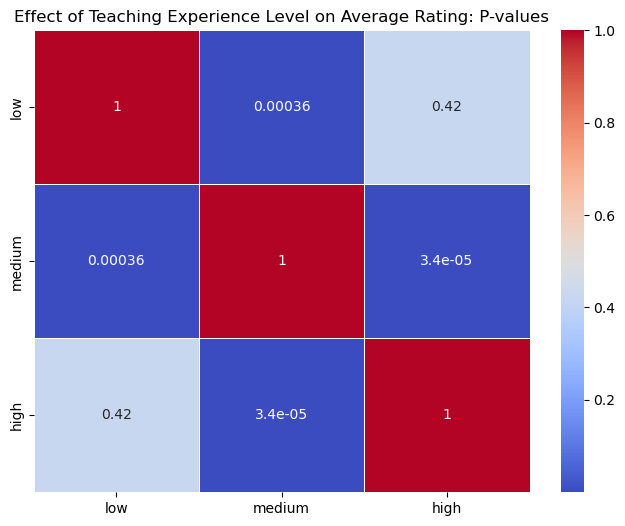

In [214]:
# Heatmap of the p-values
plt.figure(figsize=(8, 6))
sns.heatmap(dunn_results, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Effect of Teaching Experience Level on Average Rating: P-values')
plt.show()


## Problem 3: Difficulty and Average Rating

##### Data Preparation and Exploration (problem 3)

Tied ranks in Average Rating: 69963 (Ratio: 1.00)
Tied ranks in Average Difficulty: 69963 (Ratio: 1.00)


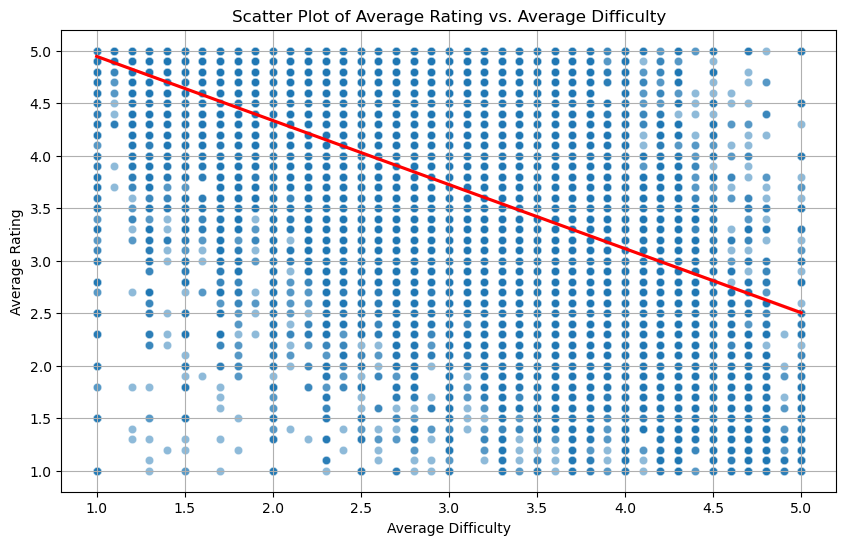

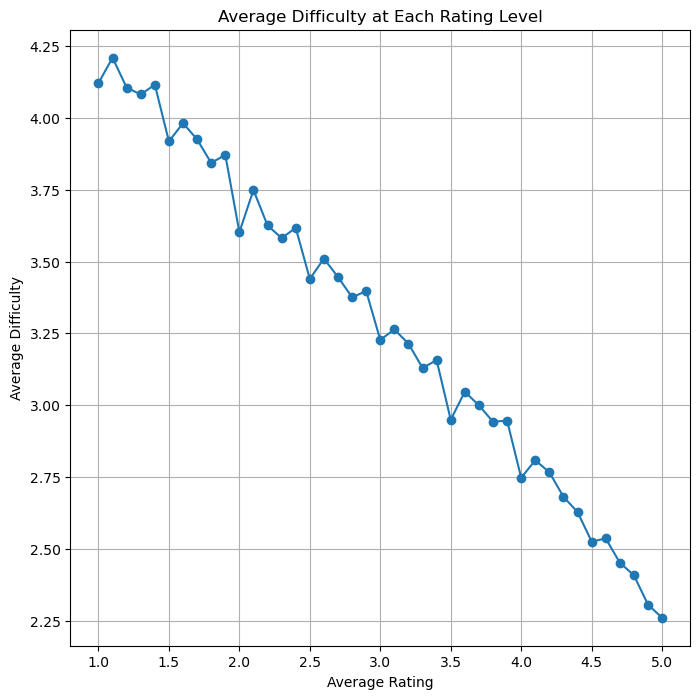

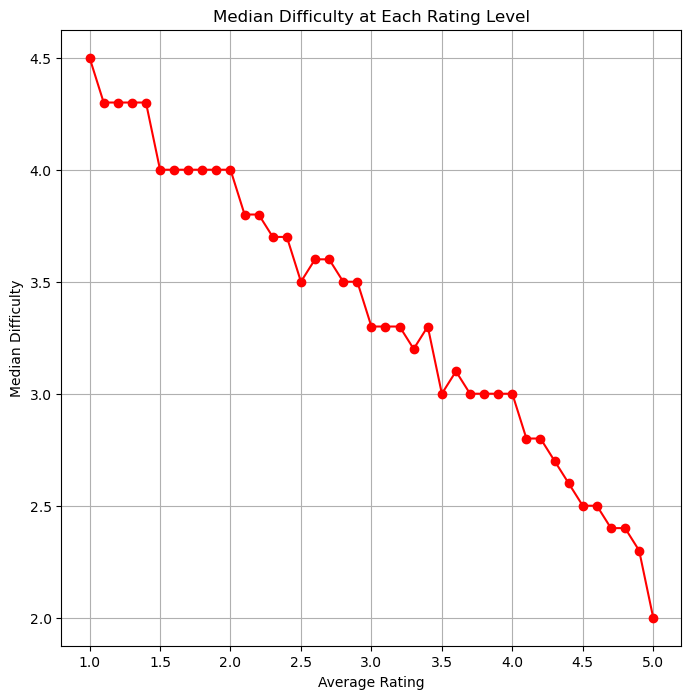

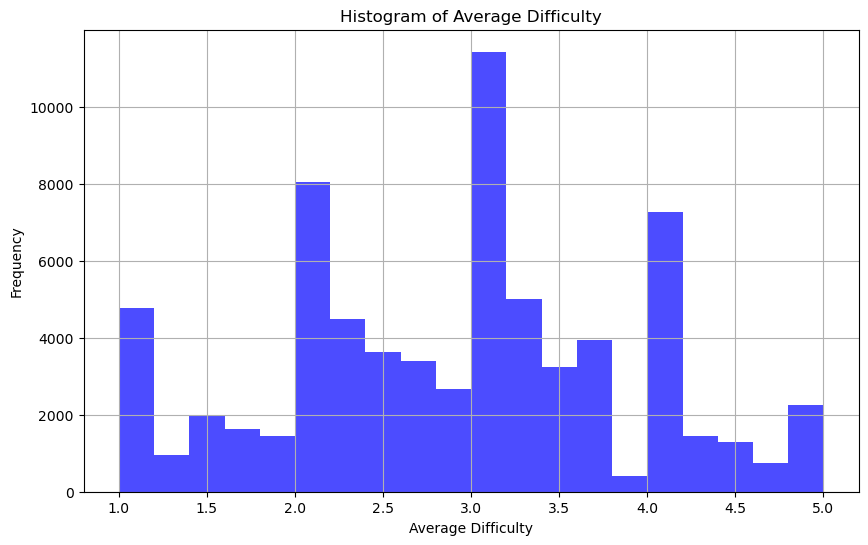

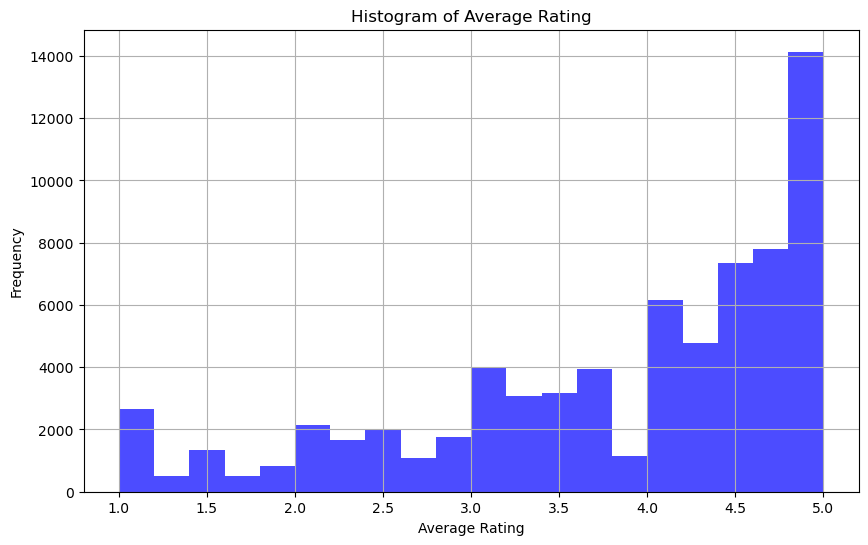

In [215]:
#----------------------------
# Step 1: Data Preparation
#----------------------------

prob3_data = df.copy()
prob3_data.dropna(subset=['average_rating', 'average_difficulty', 'num_ratings'], inplace=True)

# Assign stability based on the num_ratings column
prob3_data['rating_stability'] = pd.cut(prob3_data['num_ratings'], 
                                   bins=[0, low_stability_threshold, medium_stability_threshold, high_stability_threshold, float('inf')], 
                                   labels=['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability'],
                                   right=False)

#----------------------------
# Step 2: Data Exploration
#----------------------------

tied_r_avg_rating = prob3_data['average_rating'].duplicated().sum()
tied_r_avg_difficulty = prob3_data['average_difficulty'].duplicated().sum()
total_avg_rating = len(prob3_data['average_rating'])
total_avg_difficulty = len(prob3_data['average_difficulty'])
print(f"Tied ranks in Average Rating: {tied_r_avg_rating} (Ratio: {tied_r_avg_rating/total_avg_rating:.2f})")
print(f"Tied ranks in Average Difficulty: {tied_r_avg_difficulty} (Ratio: {tied_r_avg_difficulty/total_avg_difficulty:.2f})")


plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_difficulty', y='average_rating', data=df, alpha=0.5)
sns.regplot(x='average_difficulty', y='average_rating', data=df, scatter=False, color='red')
plt.title('Scatter Plot of Average Rating vs. Average Difficulty')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# Calculate the average difficulty at each rating level
avg_difficulty_per_rating = prob3_data.groupby('average_rating')['average_difficulty'].mean()

# Plotting the average difficulty for each rating level
plt.figure(figsize=(8, 8))
plt.plot(avg_difficulty_per_rating.index, avg_difficulty_per_rating.values, marker='o', linestyle='-')
plt.title('Average Difficulty at Each Rating Level')
plt.xlabel('Average Rating')
plt.ylabel('Average Difficulty')
plt.grid(True)
plt.show()

# Calculate the median difficulty at each rating level
median_difficulty_per_rating = prob3_data.groupby('average_rating')['average_difficulty'].median()

# Plotting the median difficulty for each rating level
plt.figure(figsize=(8, 8))
plt.plot(median_difficulty_per_rating.index, median_difficulty_per_rating.values, marker='o', linestyle='-', color='red')
plt.title('Median Difficulty at Each Rating Level')
plt.xlabel('Average Rating')
plt.ylabel('Median Difficulty')
plt.grid(True)
plt.show()


# Histogram of average_difficulty vs frequency
plt.figure(figsize=(10, 6))
plt.hist(prob3_data['average_difficulty'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Average Difficulty')
plt.xlabel('Average Difficulty')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(prob3_data['average_rating'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Solution (problem 3)

In [216]:
#----------------------------
# Spearman's Correlation
#----------------------------

# List of stability levels
stability_levels = ['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability']

# Prepare lists to store correlation results and stability levels for plotting
correlation_results = []
plot_stability_levels = []

# Calculate Spearman's correlation for each stability level and prepare data for plotting
for level in stability_levels:
    # Filter data for the current stability level
    filtered_data = prob3_data[prob3_data['rating_stability'] == level]
    
    # Perform Spearman's correlation if there are enough data points
    if len(filtered_data) > 1:
        rho, p_value = spearmanr(filtered_data['average_rating'], filtered_data['average_difficulty'])
        print(f"Spearman's rho for {level}: {rho:.3f}")
        print(f"P-value for {level}: {p_value:.2e}\n")

    else:
        print(f"Not enough data for {level} to perform Spearman's correlation.")



Spearman's rho for severely_low_stability: -0.460
P-value for severely_low_stability: 0.00e+00

Spearman's rho for low_stability: -0.529
P-value for low_stability: 0.00e+00

Spearman's rho for medium_stability: -0.594
P-value for medium_stability: 0.00e+00

Spearman's rho for high_stability: -0.636
P-value for high_stability: 0.00e+00



##### Visualizing Findings (problem 3)

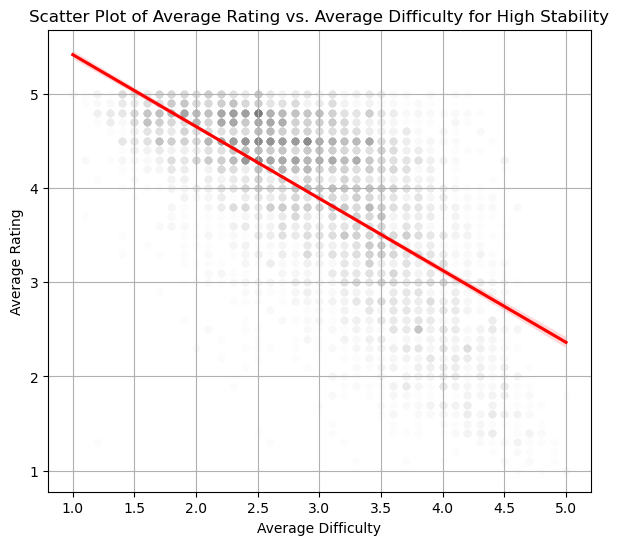

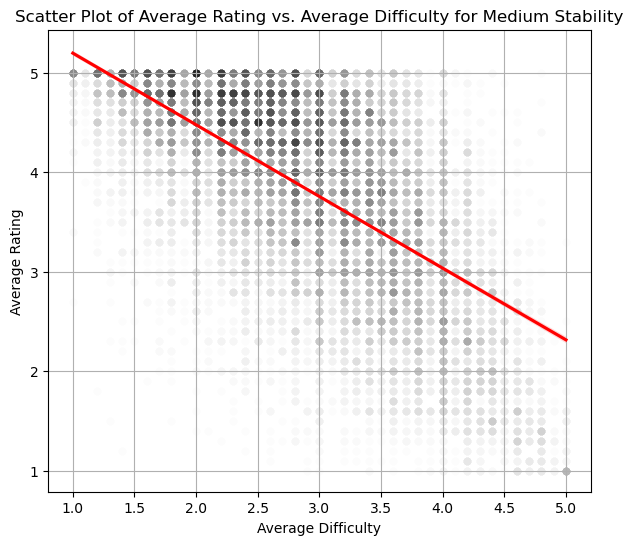

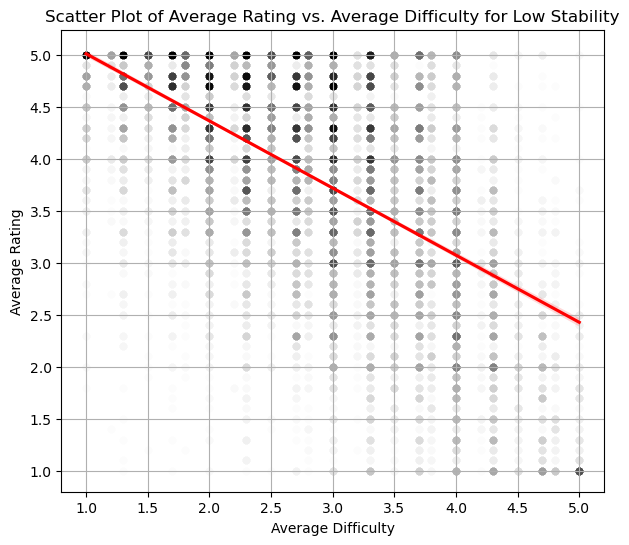

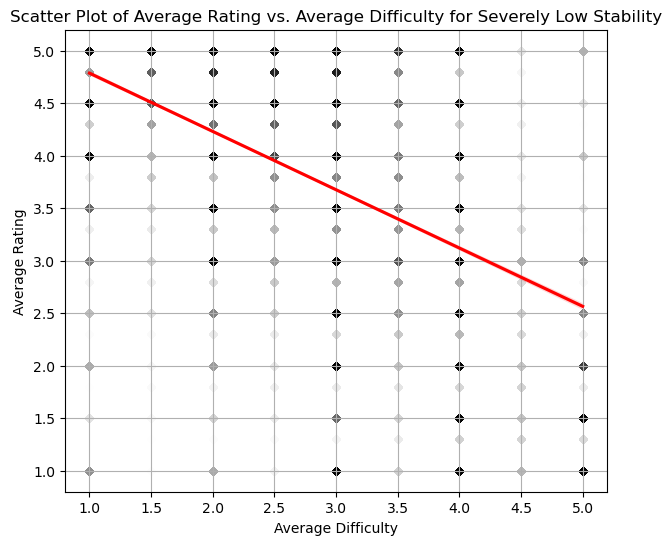

In [217]:
# Filter data for high stability
high_stability_data = prob3_data[prob3_data['rating_stability'] == 'high_stability']

plt.figure(figsize=(7, 6))
sns.scatterplot(x='average_difficulty', y='average_rating', data=high_stability_data, alpha=0.01, color='black')
sns.regplot(x='average_difficulty', y='average_rating', data=high_stability_data, scatter=False, color='red')
plt.title('Scatter Plot of Average Rating vs. Average Difficulty for High Stability')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

medium_stability_data = prob3_data[prob3_data['rating_stability'] == 'medium_stability']

plt.figure(figsize=(7, 6))
sns.scatterplot(x='average_difficulty', y='average_rating', data=medium_stability_data, alpha=0.01, color='black')
sns.regplot(x='average_difficulty', y='average_rating', data=medium_stability_data, scatter=False, color='red')
plt.title('Scatter Plot of Average Rating vs. Average Difficulty for Medium Stability')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

low_stability_data = prob3_data[prob3_data['rating_stability'] == 'low_stability']

plt.figure(figsize=(7, 6))
sns.scatterplot(x='average_difficulty', y='average_rating', data=low_stability_data, alpha=0.01, color='black')
sns.regplot(x='average_difficulty', y='average_rating', data=low_stability_data, scatter=False, color='red')
plt.title('Scatter Plot of Average Rating vs. Average Difficulty for Low Stability')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

severely_low_stability_data = prob3_data[prob3_data['rating_stability'] == 'severely_low_stability']

plt.figure(figsize=(7, 6))
sns.scatterplot(x='average_difficulty', y='average_rating', data=severely_low_stability_data, alpha=0.003, color='black')
sns.regplot(x='average_difficulty', y='average_rating', data=severely_low_stability_data, scatter=False, color='red')
plt.title('Scatter Plot of Average Rating vs. Average Difficulty for Severely Low Stability')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()



## Problem 4: Effect of Online Classes on Average Rating

##### Data Preparation and Exploration (problem 4)

Number of rows dropped: 0


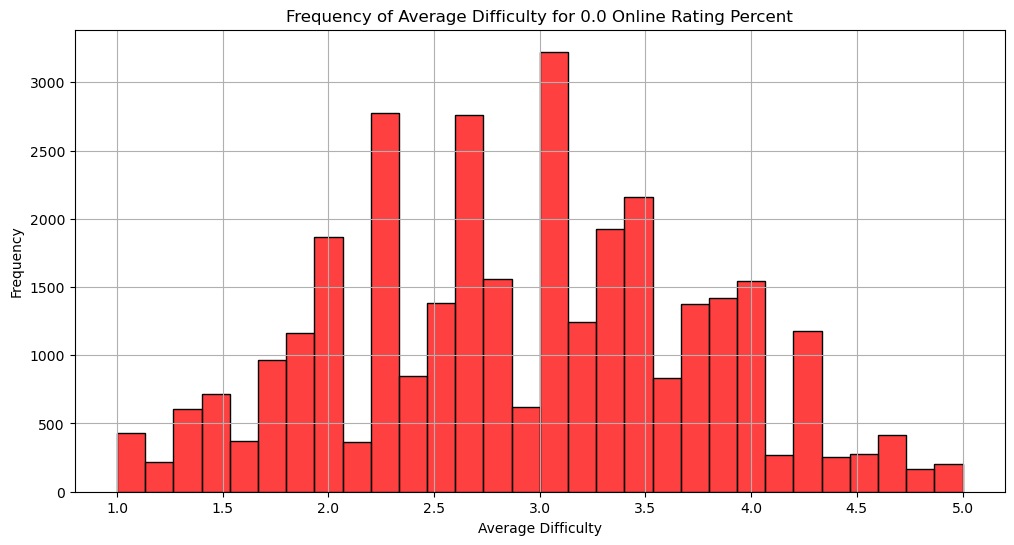

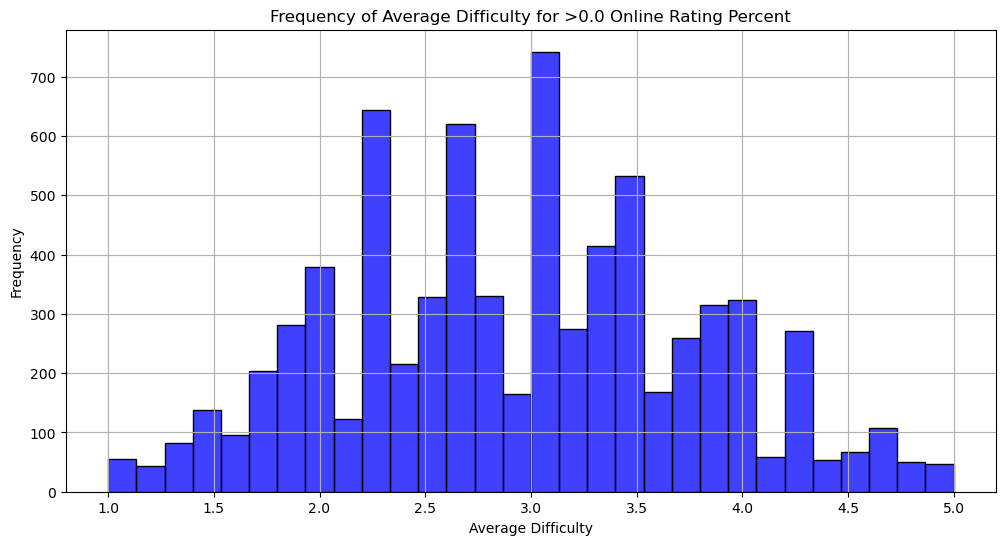

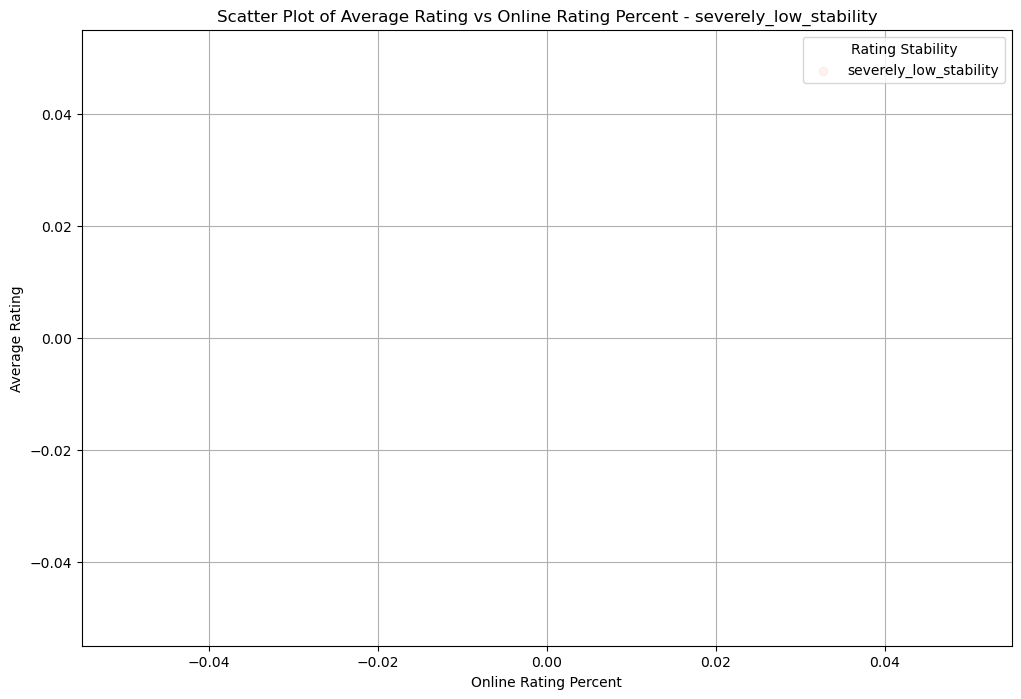

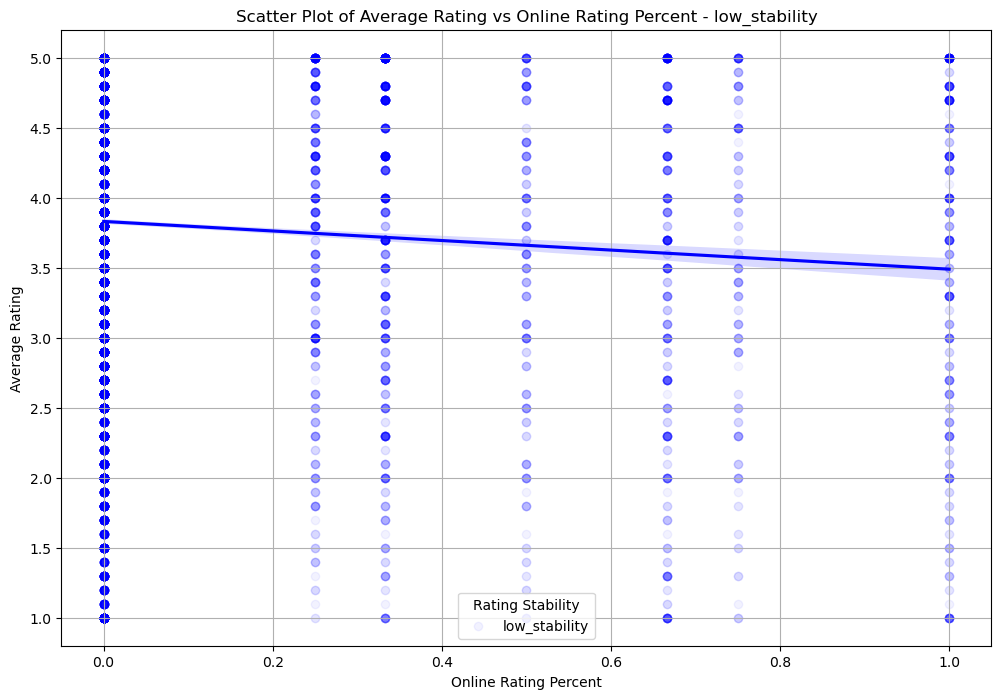

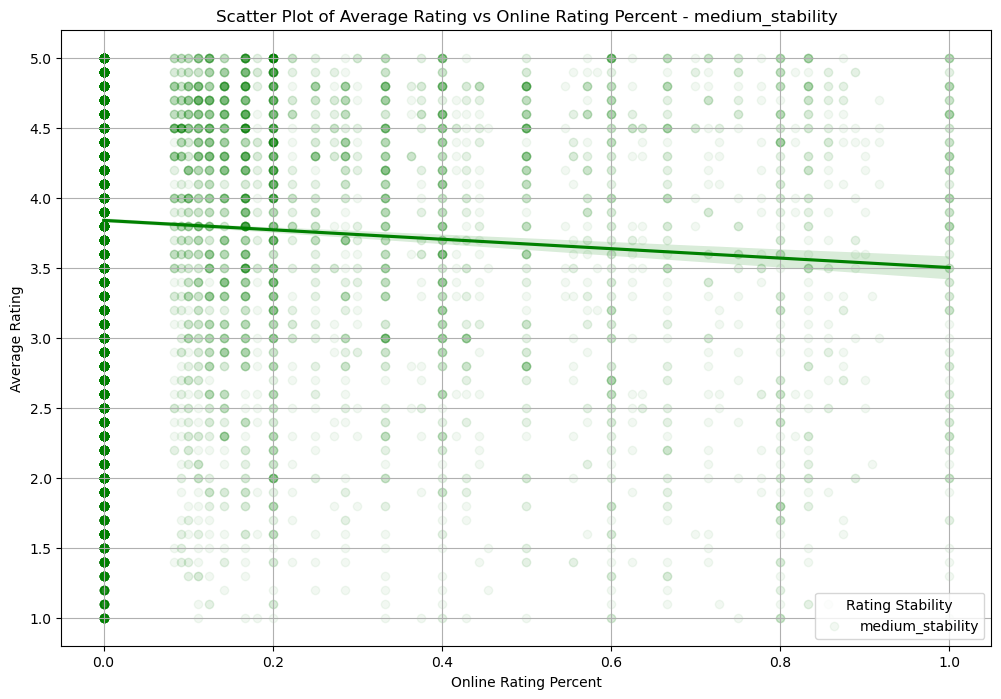

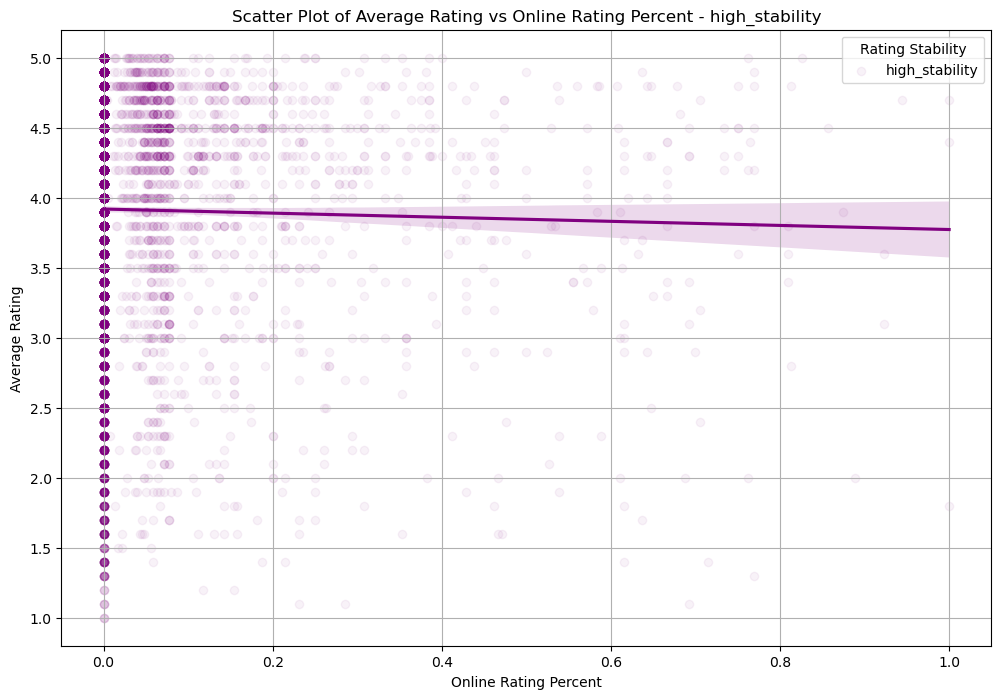

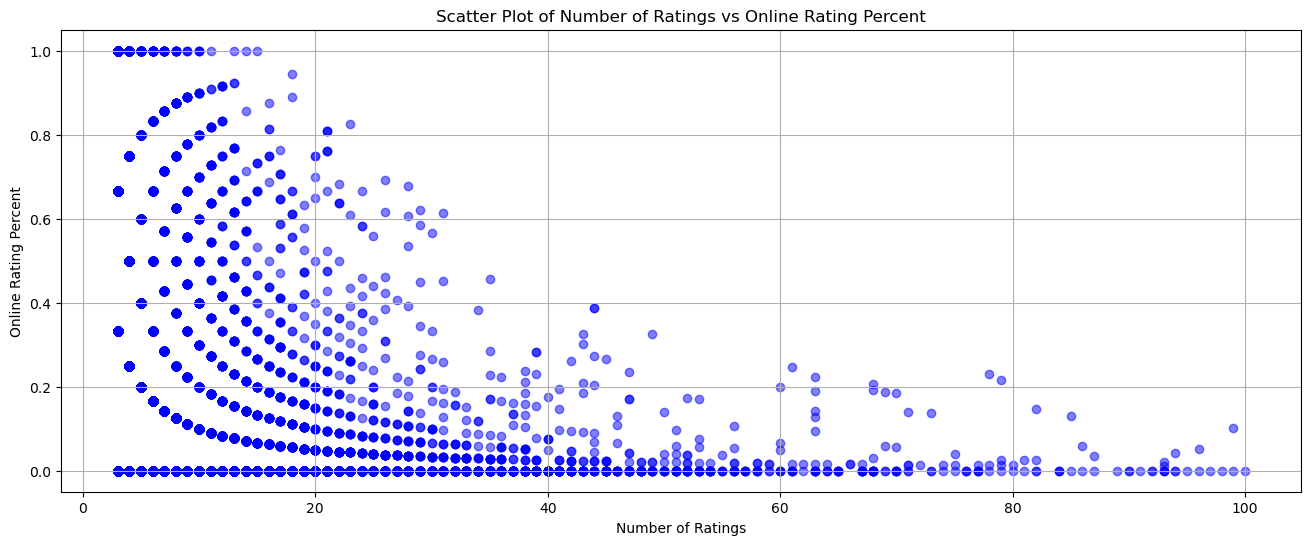

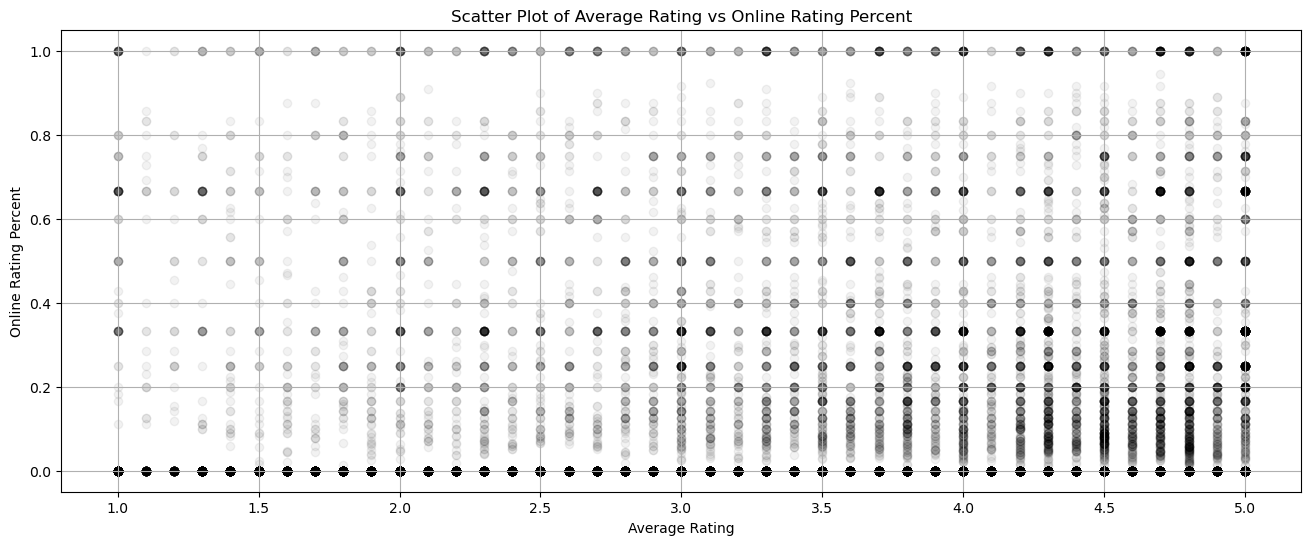

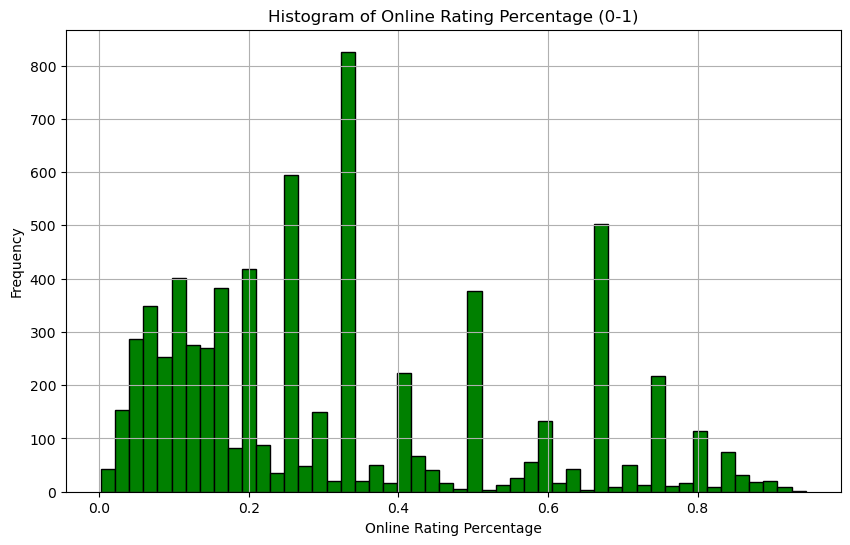

In [218]:
#----------------------------
# Step 1: Data Preparation
#----------------------------
prob4_data = df.copy()
prob4_data.dropna(subset=['average_rating', 'num_online_ratings', 'num_ratings'], inplace=True)

prob4_data['online_rating_perc'] = prob4_data['num_online_ratings'] / prob4_data['num_ratings']

# Assign stability based on the num_ratings column
prob4_data['rating_stability'] = pd.cut(prob4_data['num_ratings'], 
                                   bins=[0, low_stability_threshold, medium_stability_threshold, high_stability_threshold, float('inf')], 
                                   labels=['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability'],
                                   right=False)

prob4_data = prob4_data[prob4_data['rating_stability'] != 'severely_low_stability'] #dropping rows with less than 3 ratings to avoid serious noise
initial_row_count = prob4_data.shape[0]
prob4_data.dropna(subset=['average_rating', 'num_online_ratings', 'num_ratings', 'average_difficulty'], inplace=True)
rows_dropped = initial_row_count - prob4_data.shape[0]
print(f"Number of rows dropped: {rows_dropped}")




prob4_data['difficulty_category'] = pd.cut(prob4_data['average_difficulty'], 
                                   bins=[0, 2, 3, 4, float('inf')], 
                                   labels=['low', 'medium', 'high', 'very_high'],
                                   right=False) 



#----------------------------
# Step 2: Data Exploration
#----------------------------

# Plot average_difficulty vs frequency for prob4_data rows with 0.0 online_rating_perc
zero_online_rating = prob4_data[prob4_data['online_rating_perc'] == 0.0]
plt.figure(figsize=(12, 6))
sns.histplot(zero_online_rating['average_difficulty'], bins=30, kde=False, color='red')
plt.title('Frequency of Average Difficulty for 0.0 Online Rating Percent')
plt.xlabel('Average Difficulty')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot average_difficulty vs frequency for prob4_data rows with >0.0 online_rating_perc
greater_zero_online_rating = prob4_data[prob4_data['online_rating_perc'] > 0.0]
plt.figure(figsize=(12, 6))
sns.histplot(greater_zero_online_rating['average_difficulty'], bins=30, kde=False, color='blue')
plt.title('Frequency of Average Difficulty for >0.0 Online Rating Percent')
plt.xlabel('Average Difficulty')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Plotting average_rating vs online_rating_perc for all four stability groups in separate graphs with a line of best fit
stability_groups = ['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability']
colors = ['red', 'blue', 'green', 'purple']

for group, color in zip(stability_groups, colors):
    fig, ax = plt.subplots(figsize=(12, 8))
    subset = prob4_data[prob4_data['rating_stability'] == group]
    ax.scatter(subset['online_rating_perc'], subset['average_rating'], alpha=0.05, color=color, label=group)
    # Fit a line of best fit
    sns.regplot(x='online_rating_perc', y='average_rating', data=subset, scatter=False, color=color, ax=ax)
    ax.set_title(f'Scatter Plot of Average Rating vs Online Rating Percent - {group}')
    ax.set_xlabel('Online Rating Percent')
    ax.set_ylabel('Average Rating')
    ax.legend(title='Rating Stability')
    plt.grid(True)
    plt.show()


plt.figure(figsize=(16, 6))
filtered_data = prob4_data[(prob4_data['num_ratings'] >= 1) & (prob4_data['num_ratings'] <= 100)]
plt.scatter(filtered_data['num_ratings'], filtered_data['online_rating_perc'], alpha=0.5, color='blue')
plt.title('Scatter Plot of Number of Ratings vs Online Rating Percent')
plt.xlabel('Number of Ratings')
plt.ylabel('Online Rating Percent')
plt.grid(True)
plt.show()

# Create a scatter plot between online_rating_perc and average_rating
plt.figure(figsize=(16, 6))
plt.scatter(filtered_data['average_rating'], filtered_data['online_rating_perc'], alpha=0.05, color='black')
plt.title('Scatter Plot of Average Rating vs Online Rating Percent')
plt.xlabel('Average Rating')
plt.ylabel('Online Rating Percent')
plt.grid(True)
plt.show()

# Plot frequency of online_rating_perc for values between 0 and 1
plt.figure(figsize=(10, 6))
filtered_data = prob4_data[(prob4_data['online_rating_perc'] > 0) & (prob4_data['online_rating_perc'] < 1)]
filtered_data['online_rating_perc'].plot(kind='hist', bins=50, color='green', edgecolor='black')
plt.title('Histogram of Online Rating Percentage (0-1)')
plt.xlabel('Online Rating Percentage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()





##### Solution (problem 4)

In [219]:
#----------------------------
# Mann-Whitney U Test with effect size
#----------------------------


for difficulty_category in ['low', 'medium', 'high', 'very_high']:
    group_1 = prob4_data[(prob4_data['difficulty_category'] == difficulty_category) & (prob4_data['online_rating_perc'] == 0.0)]['average_rating']
    group_2 = prob4_data[(prob4_data['difficulty_category'] == difficulty_category) & (prob4_data['online_rating_perc'] > 0.0)]['average_rating']
    
    print(f"Difficulty Category: {difficulty_category}")
    print(f"Count of Group 1 (0% online): {len(group_1)}")
    print(f"Count of Group 2 (>0% online): {len(group_2)}")
    
    if len(group_1) > 0 and len(group_2) > 0:
        u_statistic, p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
        rank_biserial_corr = 1 - (2 * u_statistic) / (len(group_1) * len(group_2))
        
        print(f"P-value: {p_value}")
        print(f"Rank Biserial Correlation: {rank_biserial_corr}")
        print("\n")
    else:
        print("Not enough data for comparison.")
        print("\n")


Difficulty Category: low
Count of Group 1 (0% online): 4469
Count of Group 2 (>0% online): 900
P-value: 0.040143589747704274
Rank Biserial Correlation: -0.04283558340170557


Difficulty Category: medium
Count of Group 1 (0% online): 12181
Count of Group 2 (>0% online): 2802
P-value: 0.002917797876163136
Rank Biserial Correlation: -0.03591878881826527


Difficulty Category: high
Count of Group 1 (0% online): 12175
Count of Group 2 (>0% online): 2707
P-value: 6.69769600593296e-08
Rank Biserial Correlation: -0.0661940410025268


Difficulty Category: very_high
Count of Group 1 (0% online): 4315
Count of Group 2 (>0% online): 979
P-value: 6.058027352107199e-07
Rank Biserial Correlation: -0.10192607918075658




##### Visualizing Findings (problem 4)

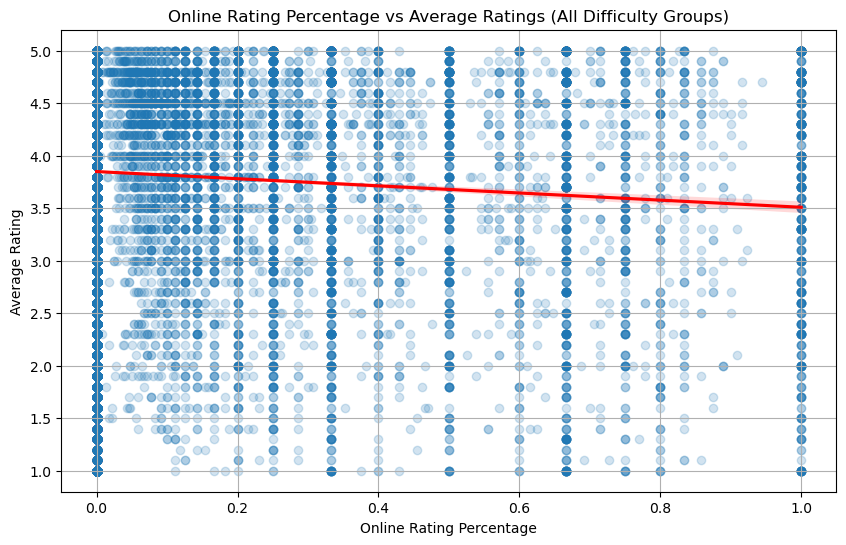

In [220]:
plt.figure(figsize=(10, 6))
sns.regplot(x='online_rating_perc', y='average_rating', data=prob4_data, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Online Rating Percentage vs Average Ratings (All Difficulty Groups)')
plt.xlabel('Online Rating Percentage')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

## Problem 5: Relationship Between Average Rating and Retake Percentage

##### Data Preparation and Exploration (problem 5)

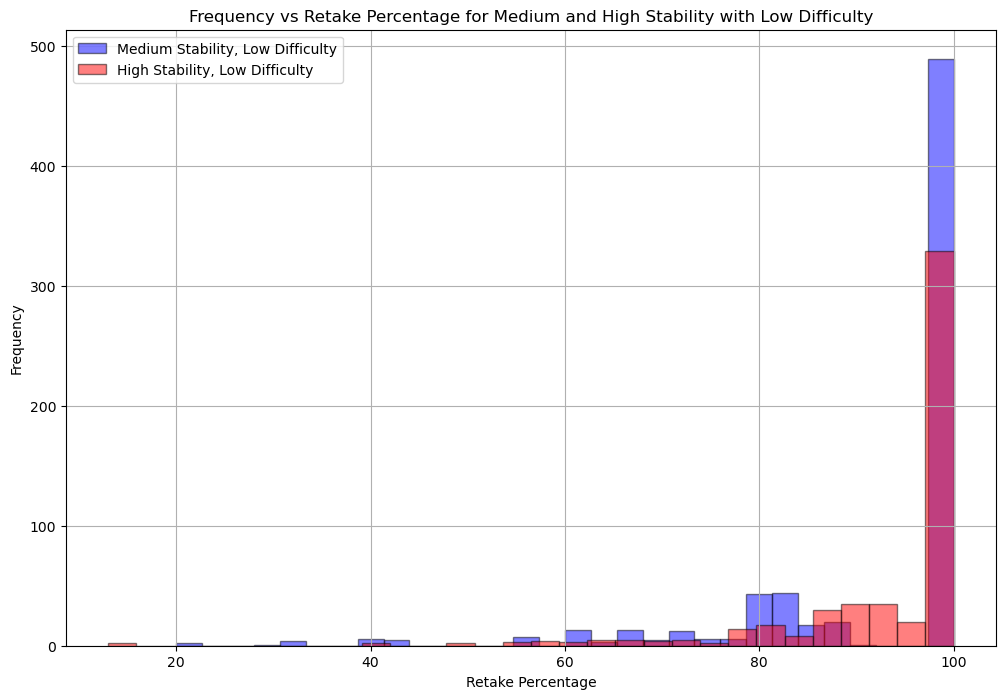

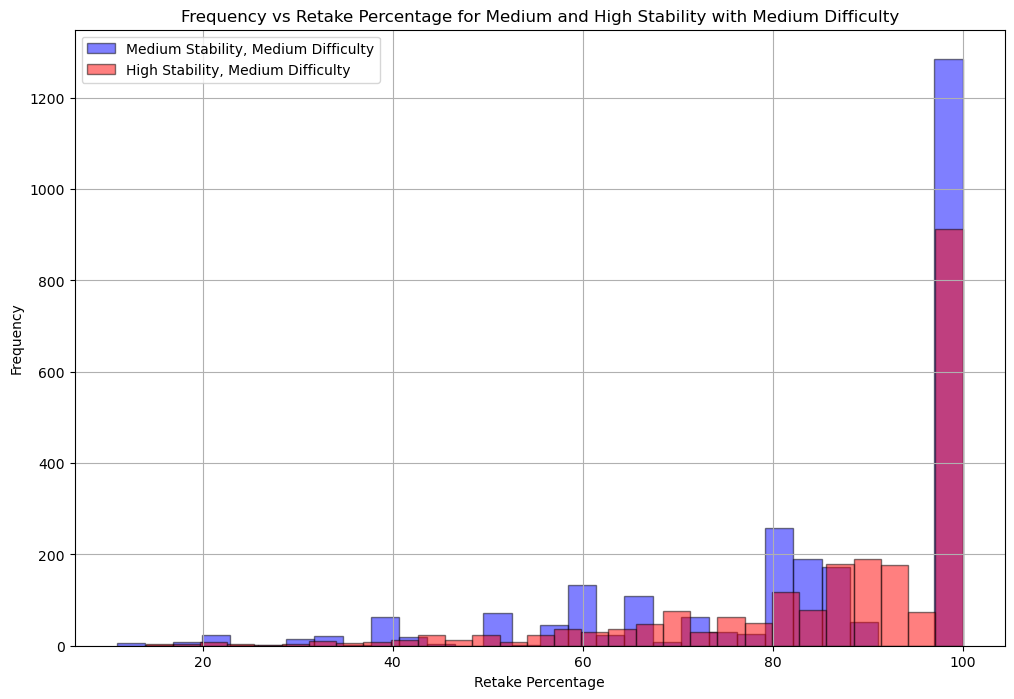

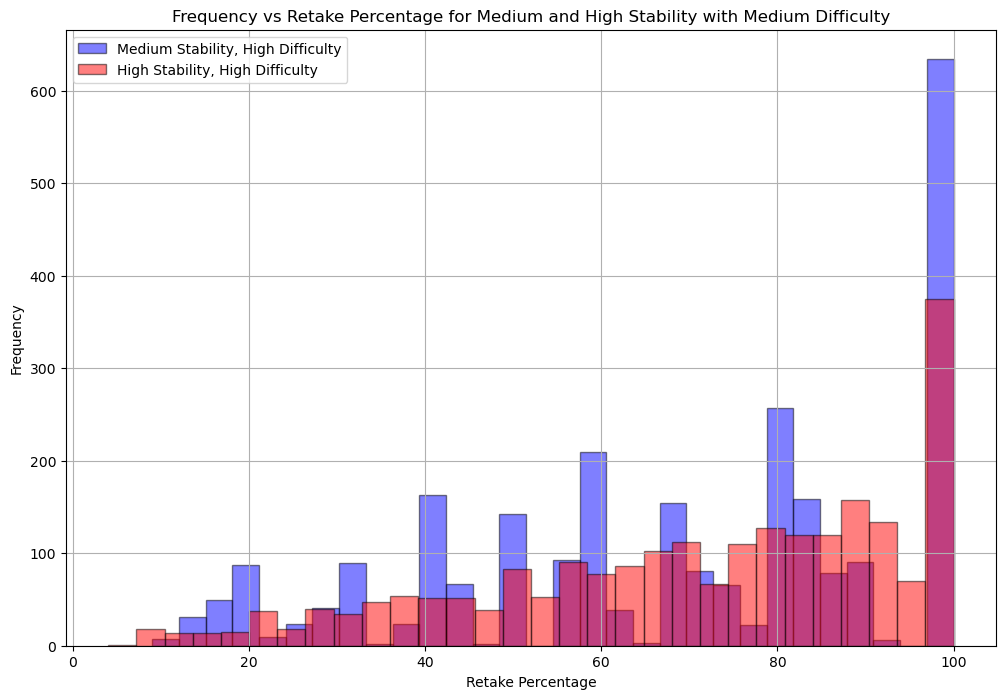

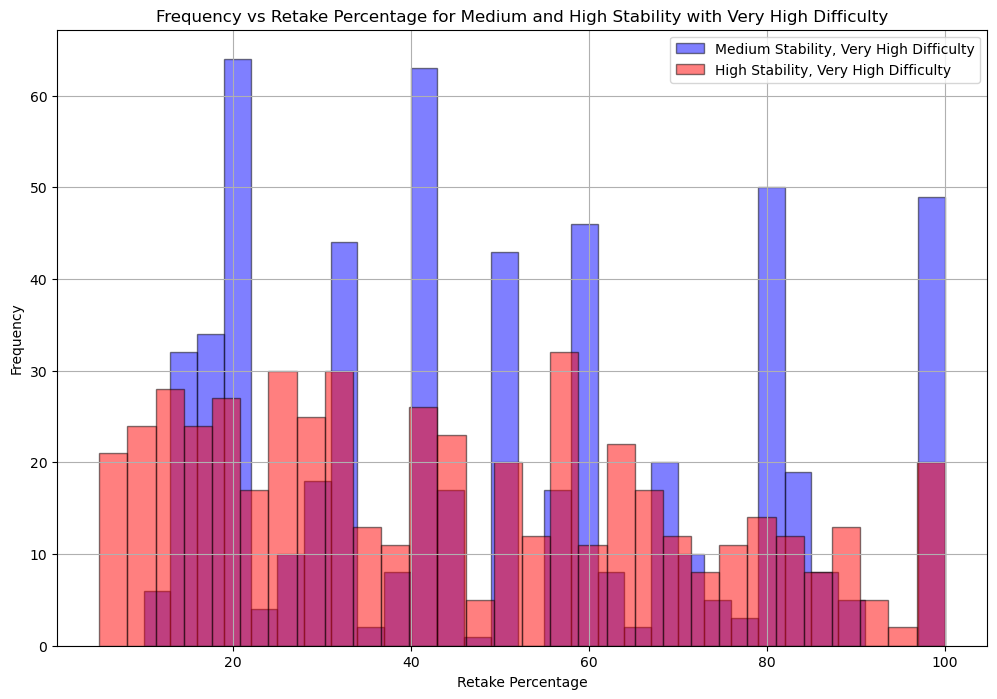

In [221]:
#----------------------------
# Step 1: Data Preparation
#----------------------------
prob5_data = df.copy()
prob5_data.dropna(subset=['average_rating', 'retake_perc', 'num_ratings', 'average_difficulty'], inplace=True)

# Assign stability based on the num_ratings column
prob5_data['rating_stability'] = pd.cut(prob5_data['num_ratings'], 
                                   bins=[0, low_stability_threshold, medium_stability_threshold, high_stability_threshold, float('inf')], 
                                   labels=['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability'],
                                   right=False)


prob5_data['difficulty_category'] = pd.cut(prob5_data['average_difficulty'], 
                                   bins=[0, 2, 3, 4, float('inf')], 
                                   labels=['low', 'medium', 'high', 'very_high'],
                                   right=False) 

# Filter data for medium and high stability with a difficulty_category of "low"
medium_stability_data_low_diff = prob5_data[(prob5_data['rating_stability'] == 'medium_stability') & (prob5_data['difficulty_category'] == 'low')]
high_stability_data_low_diff = prob5_data[(prob5_data['rating_stability'] == 'high_stability') & (prob5_data['difficulty_category'] == 'low')]


#----------------------------
# Step 2: Data Exploration
#----------------------------

plt.figure(figsize=(12, 8))
plt.hist(medium_stability_data_low_diff['retake_perc'], bins=30, alpha=0.5, label='Medium Stability, Low Difficulty', color='blue', edgecolor='black')
plt.hist(high_stability_data_low_diff['retake_perc'], bins=30, alpha=0.5, label='High Stability, Low Difficulty', color='red', edgecolor='black')
plt.xlabel('Retake Percentage')
plt.ylabel('Frequency')
plt.title('Frequency vs Retake Percentage for Medium and High Stability with Low Difficulty')
plt.legend()
plt.grid(True)
plt.show()

medium_stability_data_medium_diff = prob5_data[(prob5_data['rating_stability'] == 'medium_stability') & (prob5_data['difficulty_category'] == 'medium')]
high_stability_data_medium_diff = prob5_data[(prob5_data['rating_stability'] == 'high_stability') & (prob5_data['difficulty_category'] == 'medium')]

plt.figure(figsize=(12, 8))
plt.hist(medium_stability_data_medium_diff['retake_perc'], bins=30, alpha=0.5, label='Medium Stability, Medium Difficulty', color='blue', edgecolor='black')
plt.hist(high_stability_data_medium_diff['retake_perc'], bins=30, alpha=0.5, label='High Stability, Medium Difficulty', color='red', edgecolor='black')
plt.xlabel('Retake Percentage')
plt.ylabel('Frequency')
plt.title('Frequency vs Retake Percentage for Medium and High Stability with Medium Difficulty')
plt.legend()
plt.grid(True)
plt.show()

medium_stability_data_high_diff = prob5_data[(prob5_data['rating_stability'] == 'medium_stability') & (prob5_data['difficulty_category'] == 'high')]
high_stability_data_high_diff = prob5_data[(prob5_data['rating_stability'] == 'high_stability') & (prob5_data['difficulty_category'] == 'high')]

plt.figure(figsize=(12, 8))
plt.hist(medium_stability_data_high_diff['retake_perc'], bins=30, alpha=0.5, label='Medium Stability, High Difficulty', color='blue', edgecolor='black')
plt.hist(high_stability_data_high_diff['retake_perc'], bins=30, alpha=0.5, label='High Stability, High Difficulty', color='red', edgecolor='black')
plt.xlabel('Retake Percentage')
plt.ylabel('Frequency')
plt.title('Frequency vs Retake Percentage for Medium and High Stability with Medium Difficulty')
plt.legend()
plt.grid(True)
plt.show()

medium_stability_data_very_high_diff = prob5_data[(prob5_data['rating_stability'] == 'medium_stability') & (prob5_data['difficulty_category'] == 'very_high')]
high_stability_data_very_high_diff = prob5_data[(prob5_data['rating_stability'] == 'high_stability') & (prob5_data['difficulty_category'] == 'very_high')]

plt.figure(figsize=(12, 8))
plt.hist(medium_stability_data_very_high_diff['retake_perc'], bins=30, alpha=0.5, label='Medium Stability, Very High Difficulty', color='blue', edgecolor='black')
plt.hist(high_stability_data_very_high_diff['retake_perc'], bins=30, alpha=0.5, label='High Stability, Very High Difficulty', color='red', edgecolor='black')
plt.xlabel('Retake Percentage')
plt.ylabel('Frequency')
plt.title('Frequency vs Retake Percentage for Medium and High Stability with Very High Difficulty')
plt.legend()
plt.grid(True)
plt.show()


##### Solution (problem 5)

In [222]:
#----------------------------
# Step 1: Spearman's Correlation for medium stability professors
#----------------------------

for difficulty in ['low', 'medium', 'high', 'very_high']:
    medium_stability_data = prob5_data[(prob5_data['rating_stability'] == 'medium_stability') & (prob5_data['difficulty_category'] == difficulty)]
    rho, p_value = scipy.stats.spearmanr(medium_stability_data['retake_perc'], medium_stability_data['average_rating'])
    group_count = medium_stability_data.shape[0]
    print(f"Spearman correlation for medium stability and {difficulty} difficulty: rho={rho:.3f}, p-value={p_value:.3f}, count={group_count}")

print("\n")

#----------------------------
# Step 2: Spearman's Correlation for high stability professors
#----------------------------
for difficulty in ['low', 'medium', 'high', 'very_high']:
    high_stability_data = prob5_data[(prob5_data['rating_stability'] == 'high_stability') & (prob5_data['difficulty_category'] == difficulty)]
    rho, p_value = scipy.stats.spearmanr(high_stability_data['retake_perc'], high_stability_data['average_rating'])
    group_count = high_stability_data.shape[0]
    print(f"Spearman correlation for high stability and {difficulty} difficulty: rho={rho:.3f}, p-value={p_value:.3f}, count={group_count}")





Spearman correlation for medium stability and low difficulty: rho=0.675, p-value=0.000, count=697
Spearman correlation for medium stability and medium difficulty: rho=0.775, p-value=0.000, count=2631
Spearman correlation for medium stability and high difficulty: rho=0.847, p-value=0.000, count=2630
Spearman correlation for medium stability and very_high difficulty: rho=0.839, p-value=0.000, count=588


Spearman correlation for high stability and low difficulty: rho=0.584, p-value=0.000, count=525
Spearman correlation for high stability and medium difficulty: rho=0.746, p-value=0.000, count=2246
Spearman correlation for high stability and high difficulty: rho=0.838, p-value=0.000, count=2320
Spearman correlation for high stability and very_high difficulty: rho=0.808, p-value=0.000, count=523


##### Visualizing Findings (problem 5)

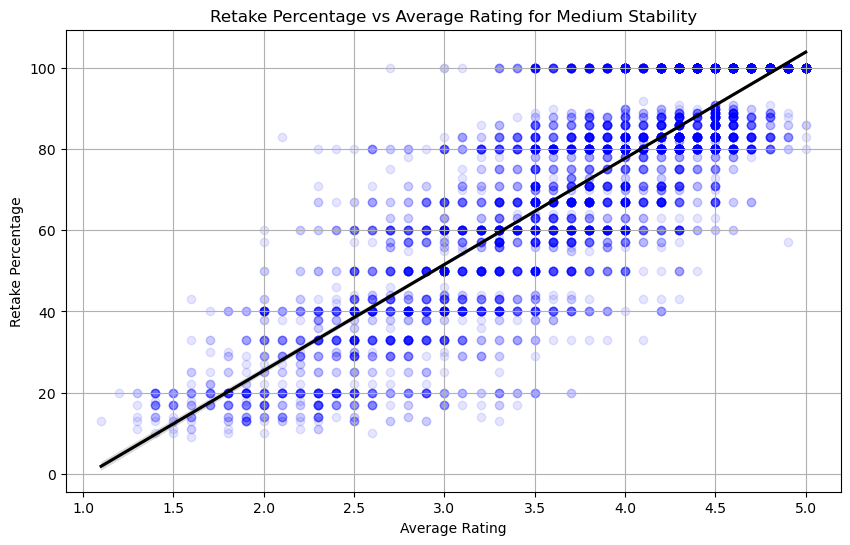

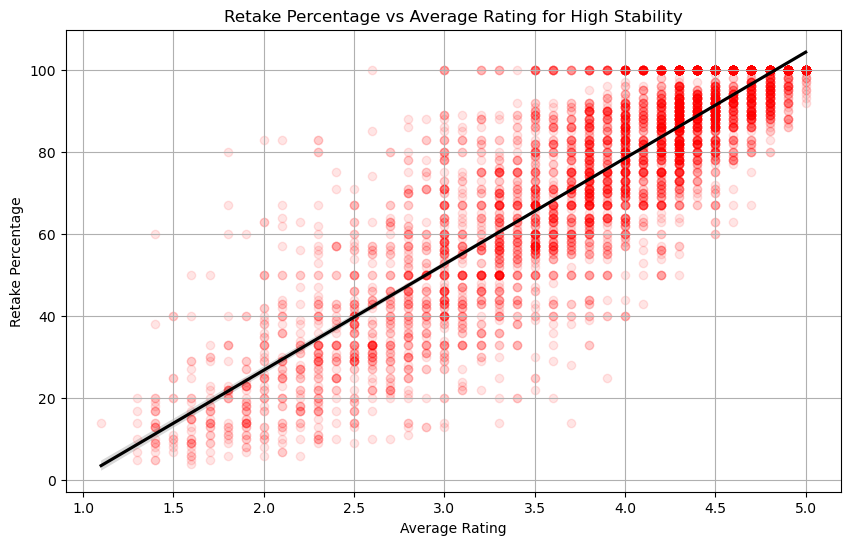

In [223]:
medium_stability_data = prob5_data[prob5_data['rating_stability'] == 'medium_stability']
plt.figure(figsize=(10, 6))
plt.scatter(medium_stability_data['average_rating'], medium_stability_data['retake_perc'], alpha=0.1, color='blue')
sns.regplot(x='average_rating', y='retake_perc', data=medium_stability_data, scatter=False, color='black')
plt.title('Retake Percentage vs Average Rating for Medium Stability')
plt.xlabel('Average Rating')
plt.ylabel('Retake Percentage')
plt.grid(True)
plt.show()

high_stability_data = prob5_data[prob5_data['rating_stability'] == 'high_stability']
plt.figure(figsize=(10, 6))
plt.scatter(high_stability_data['average_rating'], high_stability_data['retake_perc'], alpha=0.1, color='red')
sns.regplot(x='average_rating', y='retake_perc', data=high_stability_data, scatter=False, color='black')
plt.title('Retake Percentage vs Average Rating for High Stability')
plt.xlabel('Average Rating')
plt.ylabel('Retake Percentage')
plt.grid(True)
plt.show()

## Problem 6: Difference in Average Rating Based on Receiving a Pepper

##### Data Preparation (problem 6)

In [224]:
prob6_data = df.copy()
prob6_data.dropna(subset=['average_rating', 'recieved_pepper', 'num_ratings', 'average_difficulty'], inplace=True)

# Assign stability based on the num_ratings column
prob6_data['rating_stability'] = pd.cut(prob6_data['num_ratings'], 
                                   bins=[0, low_stability_threshold, medium_stability_threshold, high_stability_threshold, float('inf')], 
                                   labels=['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability'],
                                   right=False)

prob6_data['difficulty_category'] = pd.cut(prob6_data['average_difficulty'], 
                                   bins=[0, 2, 3, 4, float('inf')], 
                                   labels=['low', 'medium', 'high', 'very_high'],
                                   right=False) 

##### Solution (problem 6)

In [225]:
#----------------------------
# Step 1: Mann-Whitney U Test with effect size
#----------------------------

stability_categories = prob6_data['rating_stability'].cat.categories
difficulty_categories = prob6_data['difficulty_category'].cat.categories

results = []
for stability in stability_categories:
    print(f"Results for Stability Level: {stability}")
    stability_results = []
    for difficulty in difficulty_categories:
        subset = prob6_data[(prob6_data['rating_stability'] == stability) & (prob6_data['difficulty_category'] == difficulty)]
        group1 = subset[subset['recieved_pepper'] == 0.0]['average_rating']
        group2 = subset[subset['recieved_pepper'] == 1.0]['average_rating']
        if len(group1) > 0 and len(group2) > 0:
            stat, p = mannwhitneyu(group1, group2)
            n1 = len(group1)
            n2 = len(group2)
            rank_biserial_corr = 1 - (2 * stat) / (n1 * n2)
            stability_results.append((difficulty, 'Mann-Whitney', stat, p, 'Rank-Biserial', rank_biserial_corr))
    
    for result in stability_results:
        print(f"  {result[0]} difficulty: P-value: {result[3]}, Rank-Biserial Correlation: {result[5]}")
    print("\n")






Results for Stability Level: severely_low_stability
  low difficulty: P-value: 1.0236873565051462e-15, Rank-Biserial Correlation: 0.15316638821142115
  medium difficulty: P-value: 2.730080471147874e-40, Rank-Biserial Correlation: 0.2301213790369484
  high difficulty: P-value: 1.1949045563934773e-102, Rank-Biserial Correlation: 0.3514447401606935
  very_high difficulty: P-value: 1.1359787319679255e-121, Rank-Biserial Correlation: 0.5281720912489141


Results for Stability Level: low_stability
  low difficulty: P-value: 4.160364754164164e-34, Rank-Biserial Correlation: 0.2954811980311267
  medium difficulty: P-value: 3.9709822628785945e-94, Rank-Biserial Correlation: 0.3407826245607355
  high difficulty: P-value: 1.6179920799398413e-142, Rank-Biserial Correlation: 0.45097419679544215
  very_high difficulty: P-value: 6.327068241314099e-70, Rank-Biserial Correlation: 0.5890812295871546


Results for Stability Level: medium_stability
  low difficulty: P-value: 2.5914842905886107e-38, Rank-B

##### Visualizing Findings (problem 6)

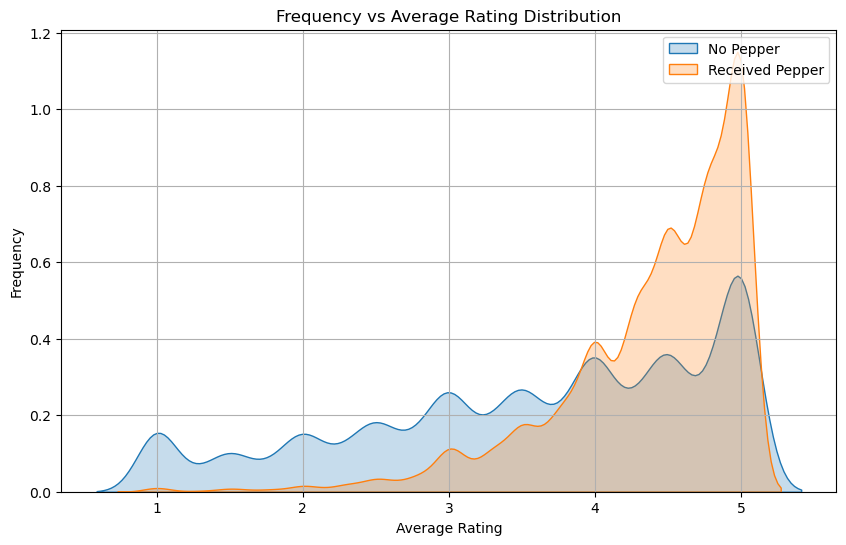

In [226]:
# Overlay the frequency vs average_rating distribution for professors who received a pepper and those who didn't
plt.figure(figsize=(10, 6))
sns.kdeplot(data=prob6_data[prob6_data['recieved_pepper'] == 0], x='average_rating', label='No Pepper', fill=True)
sns.kdeplot(data=prob6_data[prob6_data['recieved_pepper'] == 1], x='average_rating', label='Received Pepper', fill=True)
plt.title('Frequency vs Average Rating Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Problem 7: Predicting Average Rating from Average Difficulty Using OLS

##### Data Preparation (problem 7)

In [227]:
prob7_data = df.copy()
prob7_data.dropna(subset=['average_rating', 'average_difficulty', 'num_ratings'], inplace=True)

##### Solution (problem 7)

In [228]:
#----------------------------
# Performing OLS
#----------------------------


# Apply the threshold to filter out professors with low or medium rating stability
filtered_data = prob7_data[prob7_data['num_ratings'] >= high_stability_threshold]

# Prepare the features and target variable for filtered data
X_filtered = filtered_data[['average_difficulty']]
y_filtered = filtered_data['average_rating']

# Prepare the features and target variable for unfiltered data
X_unfiltered = prob7_data[['average_difficulty']]
y_unfiltered = prob7_data['average_rating']

# Initialize the linear regression model
model_filtered = LinearRegression()
model_unfiltered = LinearRegression()

# Split the data into training and testing sets for filtered data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.1, random_state=n_number)

# Split the data into training and testing sets for unfiltered data
X_train_unfiltered, X_test_unfiltered, y_train_unfiltered, y_test_unfiltered = train_test_split(
    X_unfiltered, y_unfiltered, test_size=0.1, random_state=n_number)

# Train the model and make predictions for filtered data
model_filtered.fit(X_train_filtered, y_train_filtered)
y_pred_filtered = model_filtered.predict(X_test_filtered)
rmse_filtered = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

# Train the model and make predictions for unfiltered data
model_unfiltered.fit(X_train_unfiltered, y_train_unfiltered)
y_pred_unfiltered = model_unfiltered.predict(X_test_unfiltered)
rmse_unfiltered = np.sqrt(mean_squared_error(y_test_unfiltered, y_pred_unfiltered))
r2_unfiltered = r2_score(y_test_unfiltered, y_pred_unfiltered)

# Print the results for filtered data
print("Filtered Data:")
print("RMSE:", rmse_filtered)
print("R-squared:", r2_filtered)

# Print the results for unfiltered data
print("Unfiltered Data:")
print("RMSE:", rmse_unfiltered)
print("R-squared:", r2_unfiltered)


Filtered Data:
RMSE: 0.6913551687365823
R-squared: 0.3977256531691593
Unfiltered Data:
RMSE: 0.9591994427967306
R-squared: 0.2740404281750879


##### Visualizing Findings (problem 7)

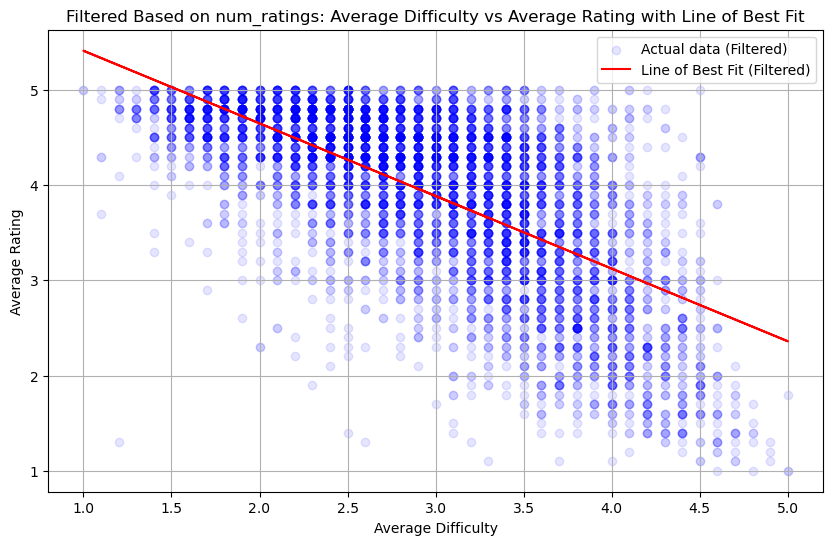

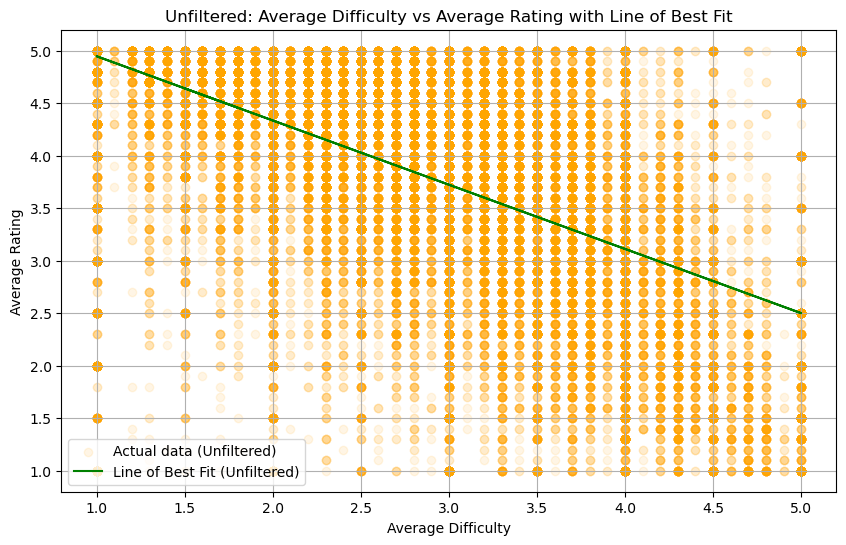

In [229]:
# Plotting the results with the line of best fit for filtered data
plt.figure(figsize=(10, 6))
plt.scatter(X_filtered['average_difficulty'], y_filtered, color='blue', alpha=0.1, label='Actual data (Filtered)')
plt.plot(X_filtered['average_difficulty'], model_filtered.predict(X_filtered), color='red', label='Line of Best Fit (Filtered)')
plt.title('Filtered Based on num_ratings: Average Difficulty vs Average Rating with Line of Best Fit')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the results with the line of best fit for unfiltered data
plt.figure(figsize=(10, 6))
plt.scatter(X_unfiltered['average_difficulty'], y_unfiltered, color='orange', alpha=0.1, label='Actual data (Unfiltered)')
plt.plot(X_unfiltered['average_difficulty'], model_unfiltered.predict(X_unfiltered), color='green', label='Line of Best Fit (Unfiltered)')
plt.title('Unfiltered: Average Difficulty vs Average Rating with Line of Best Fit')
plt.xlabel('Average Difficulty')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)
plt.show()

## Problem 8: Regression Model to Predict Average Rating Based on All Data

##### Data Preparation (problem 8)

In [230]:
# ------------------------------------------------------------------------------------------------
# Cleaning rows and dropping unnecessary columns
# ------------------------------------------------------------------------------------------------
prob8_data = df.copy()

print("Starting with ", prob8_data.shape[0], " rows")

prob8_data.drop(columns=['retake_perc'], inplace=True)
prob8_data.dropna(subset=['average_rating'], inplace=True) 
prob8_data.drop(columns=['field', 'university', 'state'], inplace=True)

# Calculate the percentage of online ratings instead of the number of online ratings
prob8_data['online_rating_perc'] = (prob8_data['num_online_ratings'] / prob8_data['num_ratings']) * 100
prob8_data.drop(columns=['num_online_ratings'], inplace=True)


Starting with  89893  rows


##### Solution (problem 8)

In [231]:
# ------------------------------------------------------------------------------------------------
# Training a ridge regression model to predict average_rating
# ------------------------------------------------------------------------------------------------

# Selecting features and target variable
X = prob8_data[['average_difficulty', 'recieved_pepper']]
y = prob8_data['average_rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n_number)

# Training the Ridge Regression model
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = ridge_model.predict(X_test)

# Displaying the coefficients of the model
print("Coefficients of the model:", ridge_model.coef_)

# Calculating the score of the model on the test set
print("R^2 score on test set:", ridge_model.score(X_test, y_test))

# Calculating RMSE for the model on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse)

Coefficients of the model: [-0.57269605  0.63168221]
R^2 score on test set: 0.3448203195837459
RMSE on test set: 0.9189768683475338


##### Visualizing Findings (problem 8)

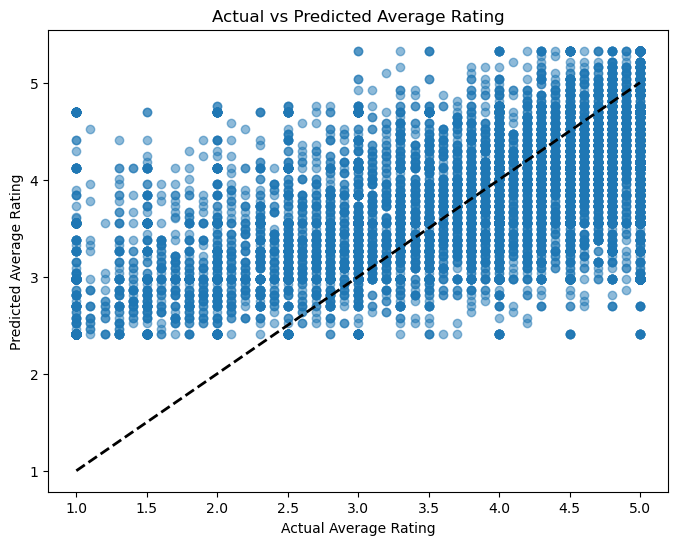

In [232]:
# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Average Rating')
plt.ylabel('Predicted Average Rating')
plt.title('Actual vs Predicted Average Rating')
plt.show()

## Problem 9: Predicting Received Pepper Based on Average Rating

##### Data Preparation (problem 9)

In [233]:
# Copy the original DataFrame
prob9_data = df.copy()

# Drop rows with missing values in 'average_rating' or 'recieved_pepper'
prob9_data.dropna(subset=['average_rating', 'recieved_pepper'], inplace=True)

# Select only the relevant columns
prob9_data = prob9_data[['average_rating', 'recieved_pepper']]

# Display the number of rows
print("Number of rows in prob9_data:", prob9_data.shape[0])

# Display class distribution
pepper_counts = prob9_data['recieved_pepper'].value_counts(normalize=True) * 100
print("Percentage of professors with recieved_pepper = 1:", pepper_counts[1], "%")
print("Percentage of professors with recieved_pepper = 0:", pepper_counts[0], "%")

Number of rows in prob9_data: 70004
Percentage of professors with recieved_pepper = 1: 27.992686132221017 %
Percentage of professors with recieved_pepper = 0: 72.00731386777899 %


##### Solution (problem 9)

In [234]:
# ----------------------------------------
# Step 1:Handling Class Imbalance with Class Weights
# ----------------------------------------

# Define features and target
X = prob9_data[['average_rating']]
y = prob9_data['recieved_pepper']

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=n_number, stratify=y)

# ----------------------------------------
# Step 2: Training the Logistic Regression Model with Class Weights
# ----------------------------------------

# Initialize the Logistic Regression model with balanced class weights
log_reg = LogisticRegression(class_weight='balanced', random_state=n_number)

# Train the model
log_reg.fit(X_train, y_train)

# ----------------------------------------
# Step 3: Making Predictions
# ----------------------------------------

# Predict class labels
y_pred = log_reg.predict(X_test)

# Predict probabilities
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.60      0.70     10082
         1.0       0.42      0.75      0.54      3919

    accuracy                           0.64     14001
   macro avg       0.64      0.67      0.62     14001
weighted avg       0.74      0.64      0.66     14001



##### Visualizing Findings (problem 9)

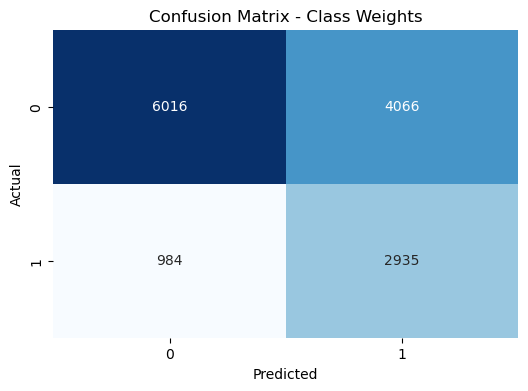

Accuracy: 0.6393114777515891


/var/folders/22/nj5n1yc16qg46gjfc5b_npsm0000gn/T/ipykernel_47734/2160747045.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='navy')


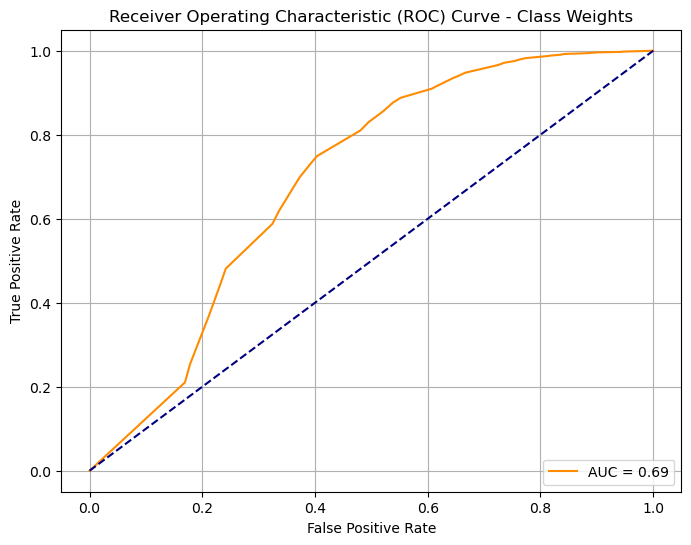

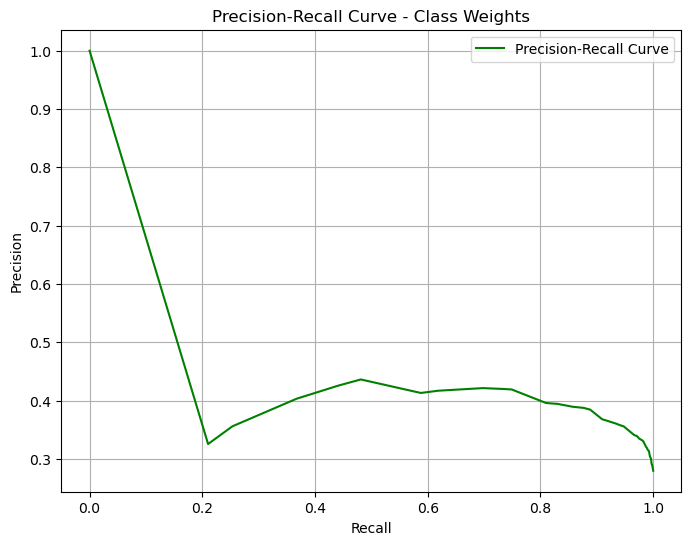

In [235]:
# ----------------------------------------
# Evaluating the Model
# ----------------------------------------

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Class Weights')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', color='navy')
plt.title('Receiver Operating Characteristic (ROC) Curve - Class Weights')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='green')
plt.title('Precision-Recall Curve - Class Weights')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Problem 10: Predicting Received Pepper Based on All Data

##### Data Preparation and PCA (problem 10)

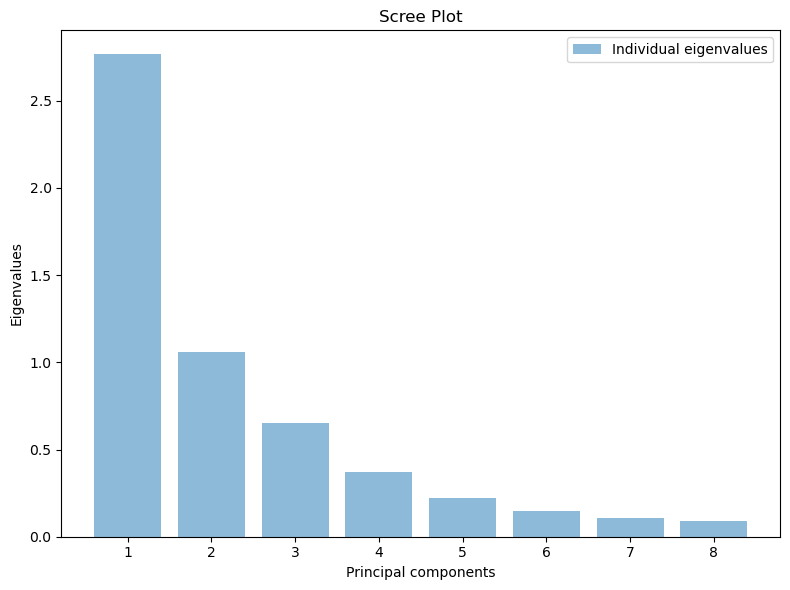

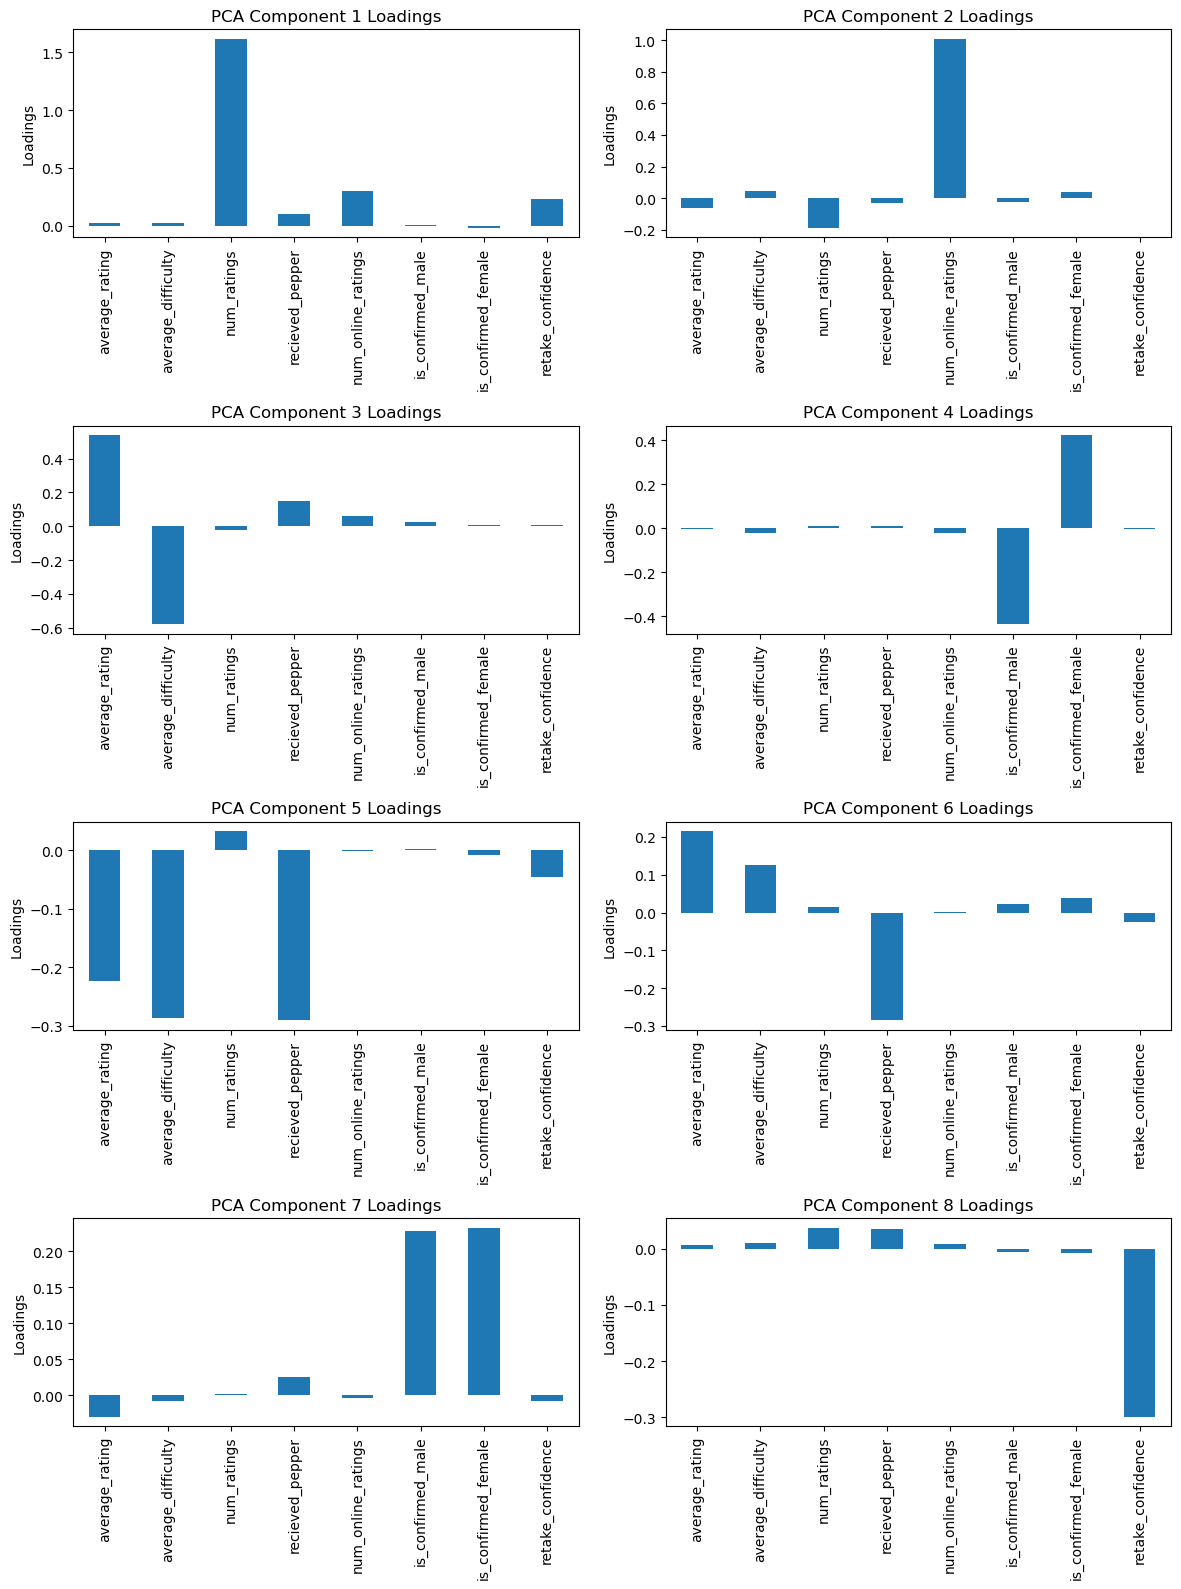

In [236]:
prob10_data = df.copy()

# ------------------------------------------------------------------------------------------------
# Step 1: Cleaning the data
# ------------------------------------------------------------------------------------------------

prob10_data.drop(['field', 'university', 'state'], axis=1, inplace=True)
prob10_data.dropna(subset=['average_rating'], inplace=True)

prob10_data['retake_confidence'] = 0 

# Conditions for assigning 1
condition_1 = (prob10_data['retake_perc'] >= 0.6) & (prob10_data['num_ratings'] >= 13)
condition_2 = (prob10_data['retake_perc'] >= 0.75) & (prob10_data['num_ratings'] >= 5)
prob10_data.loc[condition_1 | condition_2, 'retake_confidence'] = 1

# Conditions for assigning -1
condition_3 = (prob10_data['retake_perc'] <= 0.4) & (prob10_data['num_ratings'] >= 13)
condition_4 = (prob10_data['retake_perc'] <= 0.25) & (prob10_data['num_ratings'] >= 5)
prob10_data.loc[condition_3 | condition_4, 'retake_confidence'] = -1

prob10_data.drop('retake_perc', axis=1, inplace=True)

# ------------------------------------------------------------------------------------------------
# Step 2: Standardizing the data to prepare for PCA
# ------------------------------------------------------------------------------------------------


# Using all columns for PCA
X = prob10_data

# Applying Robust Scaling to prepare for PCA
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)



# ------------------------------------------------------------------------------------------------
# Step 3:Performing PCA
# ------------------------------------------------------------------------------------------------


# Performing PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Naming the principal components according to their loading matrix
component_names = [
    "professor_establishment", # retake_confidence, num_ratings, and online_ratings all positive 
    "online_ratings",   # online_ratings and num_ratings inversely correlated
    "quality_difficulty_ratio", # average_rating and average_difficulty inversely correlated
    "gender" # confirmed male and confirmed female inversely correlated
] + [f"Component_{i+1}" for i in range(4, len(pca.components_))]


# ------------------------------------------------------------------------------------------------
# Step 4: Visualizing the PCA results
# ------------------------------------------------------------------------------------------------

# Scree plot using eigenvalues
eigenvalues = pca.explained_variance_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.5, align='center', label='Individual eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('Principal components')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Creating a loading matrix for each principal component to see the makeup of variables
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(len(explained_variance))], index=prob10_data.columns)

# Plotting the loading matrix as individual bar plots for each principal component, two per row
num_components = loading_matrix.shape[1]
rows = (num_components + 1) // 2 
fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))  
axes = axes.flatten() 
for i in range(num_components):
    loading_matrix.iloc[:, i].plot(kind='bar', ax=axes[i])
    axes[i].set_ylabel('Loadings')
    axes[i].set_title(f'PCA Component {i+1} Loadings')
for j in range(num_components, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


##### Solution (problem 10)

In [237]:
# ------------------------------------------------------------------------------------------------
# Step 1:Training a logistic regression model to predict recieved_pepper based on the first three principal components
# ------------------------------------------------------------------------------------------------

# Selecting the first three principal components
X_pca = pca.transform(X_scaled)[:, :2]
y = prob10_data['recieved_pepper']

# Computing class weights due to class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=n_number)

# Training the logistic regression model with class weights
log_reg = LogisticRegression(class_weight=class_weights_dict)
log_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = log_reg.predict(X_test)



# ------------------------------------------------------------------------------------------------
# Step 2: Evaluating the model using cross validation and auroc
# ------------------------------------------------------------------------------------------------

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Performing K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=n_number)
cv_scores = cross_val_score(log_reg, X_pca, y, cv=kf)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Assessing potential overfitting
train_accuracy = accuracy_score(y_train, log_reg.predict(X_train))
print(f"Training set accuracy: {train_accuracy:.2f}")
print(f"Test set accuracy: {accuracy:.2f}")
if train_accuracy > accuracy:
    print("Model may be overfitting.")
else:
    print("Model is generalizing well.")

import sklearn.metrics as metrics

print("AUROC:", roc_auc)
# Printing out accuracy vs precision
precision_score = metrics.precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision_score:.2f}")





Accuracy: 0.70
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79     15157
         1.0       0.47      0.48      0.47      5845

    accuracy                           0.70     21002
   macro avg       0.63      0.63      0.63     21002
weighted avg       0.70      0.70      0.70     21002

Cross-validation scores: [0.69945004 0.69502178 0.69166488 0.69987858 0.703     ]
Mean cross-validation score: 0.6978030569245054
Training set accuracy: 0.70
Test set accuracy: 0.70
Model is generalizing well.
AUROC: 0.6946318448482586
Accuracy: 0.70, Precision: 0.47


##### Visualizing Findings (problem 10)

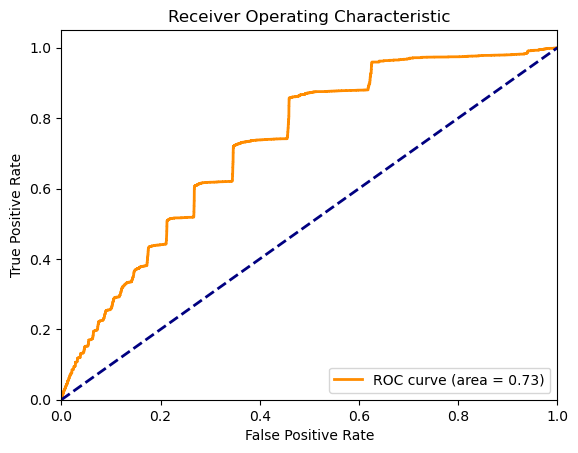

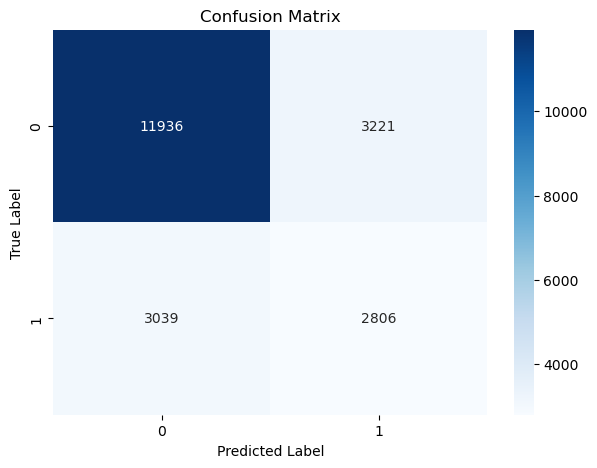

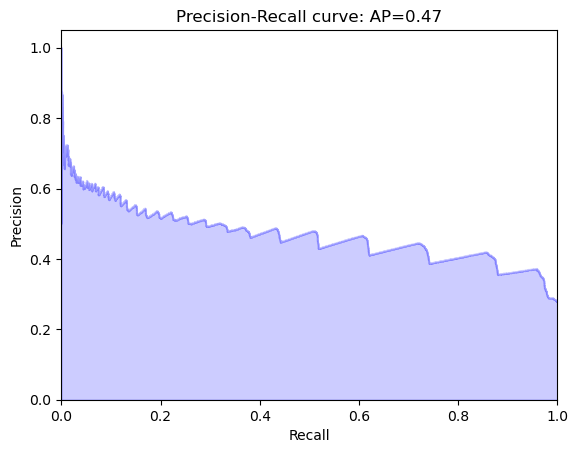

In [238]:
# ROC Curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
average_precision = average_precision_score(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


## Extra Credit: Evaluating Difference in Average Difficulty Between STEM and Non-STEM Professors

##### Data Preparation and Exploration (extra credit)

In [239]:
# ------------------------------------------------------------------------------------------------
# Cleaning data and creating new columns for stability level, quality level, and STEM professors
# ------------------------------------------------------------------------------------------------

extra_credit_data = df.copy()
extra_credit_data.dropna(subset=['average_rating', 'average_difficulty', 'num_ratings', 'field'], inplace=True)

# Assign stability based on the num_ratings column
extra_credit_data['rating_stability'] = pd.cut(extra_credit_data['num_ratings'], 
                                   bins=[0, low_stability_threshold, medium_stability_threshold, high_stability_threshold, float('inf')], 
                                   labels=['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability'],
                                   right=False)

extra_credit_data['rating_quality_category'] = pd.cut(extra_credit_data['average_rating'], 
                                   bins=[0, 2, 4, float('inf')], 
                                   labels=['low', 'medium', 'high'],
                                   right=False) 



field_counts = extra_credit_data['field'].value_counts()
print(field_counts[field_counts > 500])

# Define STEM fields
stem_fields = ["Mathematics", "Biology", "Chemistry", "Computer Science", "Nursing", "Engineering", "Economics", "Accounting", "Health Science", "Physics", "Science"]

# Create a new column 'is_stem_prof' based on the conditions provided
extra_credit_data['is_stem_prof'] = extra_credit_data['field'].apply(lambda x: 1 if x in stem_fields else (-1 if field_counts[x] <= 500 else 0))


field
English              6398
Mathematics          5557
Biology              3328
Psychology           3300
Business             2510
Communication        2142
Chemistry            2028
Computer Science     2005
Education            1867
History              1827
Nursing              1537
Sociology            1467
Engineering          1381
Economics            1289
Accounting           1240
Philosophy           1120
Languages            1112
Music                1103
Health Science       1055
Political Science    1052
Criminal Justice      977
Physics               936
Management            813
Art                   773
Social Work           703
Anthropology          683
Science               669
Humanities            616
Marketing             609
Writing               597
Finance               507
Name: count, dtype: int64


##### Solution (extra credit)

In [240]:
# ------------------------------------------------------------------------------------------------
# Performing a mann-whitney u test on average_difficulty between STEM and non-STEM professors accross all levels of quality and difficulty
# ------------------------------------------------------------------------------------------------


# Filter data for severely low stability
severely_low_stability_data = extra_credit_data[extra_credit_data['rating_stability'] == 'severely_low_stability']
low_stability_data = extra_credit_data[extra_credit_data['rating_stability'] == 'low_stability']
medium_stability_data = extra_credit_data[extra_credit_data['rating_stability'] == 'medium_stability']
high_stability_data = extra_credit_data[extra_credit_data['rating_stability'] == 'high_stability']

results = []

# Stability categories
stability_categories = ['severely_low_stability', 'low_stability', 'medium_stability', 'high_stability']

# Perform tests across all stability and difficulty categories
for stability in stability_categories:
    stability_data = extra_credit_data[extra_credit_data['rating_stability'] == stability]
    
    for quality in ['low', 'medium', 'high']:
        # Filter data by difficulty
        quality_data = stability_data[stability_data['rating_quality_category'] == quality]
        
        # Separate STEM and non-STEM professor ratings
        stem_ratings = quality_data[quality_data['is_stem_prof'] == 1]['average_difficulty']
        non_stem_ratings = quality_data[quality_data['is_stem_prof'] == -1]['average_difficulty']
        
        # Perform Mann-Whitney U Test
        if len(stem_ratings) > 0 and len(non_stem_ratings) > 0:
            u_stat, p_value = mannwhitneyu(stem_ratings, non_stem_ratings, alternative='two-sided')
            n1 = len(stem_ratings)
            n2 = len(non_stem_ratings)
            rank_biserial_corr = 1 - (2 * u_stat / (n1 * n2))
            results.append((stability, difficulty, u_stat, p_value, rank_biserial_corr))
        else:
            results.append((stability, difficulty, None, None, None))
    


for index, result in enumerate(results):
    print(f"Stability: {result[0]}, Quality: {result[1]},  P-value: {result[3]}, Rank Biserial Correlation: {result[4]}")
    if (index + 1) % 4 == 0:
        print()  # Print a line break after every 4th iteration
        


Stability: severely_low_stability, Quality: very_high,  P-value: 6.94602763848388e-05, Rank Biserial Correlation: -0.09598416630056184
Stability: severely_low_stability, Quality: very_high,  P-value: 2.805299532411758e-14, Rank Biserial Correlation: -0.12328906788510907
Stability: severely_low_stability, Quality: very_high,  P-value: 4.299028161067199e-27, Rank Biserial Correlation: -0.12165960813295795
Stability: low_stability, Quality: very_high,  P-value: 0.05686033991207665, Rank Biserial Correlation: -0.08601289068126161

Stability: low_stability, Quality: very_high,  P-value: 1.0264177716747784e-16, Rank Biserial Correlation: -0.16505855792295754
Stability: low_stability, Quality: very_high,  P-value: 6.467515665645503e-27, Rank Biserial Correlation: -0.18706069051745944
Stability: medium_stability, Quality: very_high,  P-value: 0.0009797410487899945, Rank Biserial Correlation: -0.15448159696090036
Stability: medium_stability, Quality: very_high,  P-value: 4.093584594661918e-29, 

##### Visualizing Findings (extra credit)

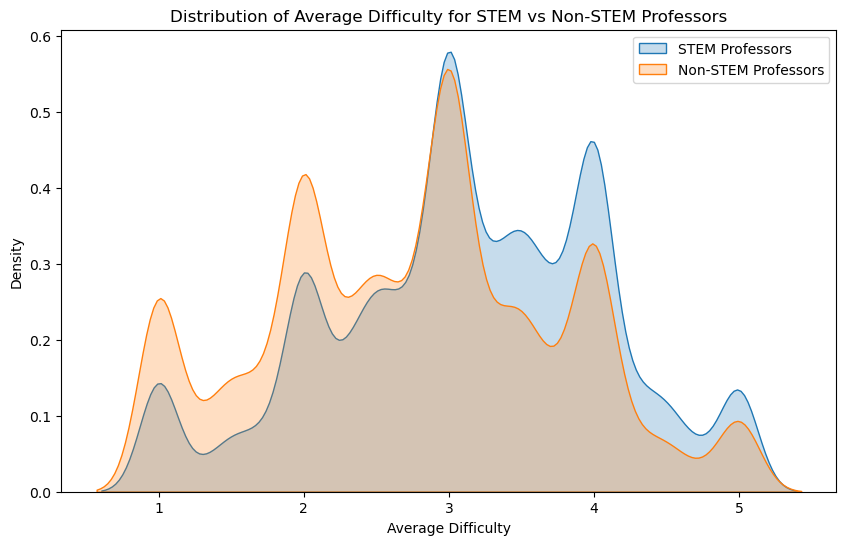

In [241]:
# Extracting average_difficulty for STEM and non-STEM professors
stem_difficulties = extra_credit_data[extra_credit_data['is_stem_prof'] == 1]['average_difficulty']
non_stem_difficulties = extra_credit_data[extra_credit_data['is_stem_prof'] == -1]['average_difficulty']

# Plotting the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(stem_difficulties, label='STEM Professors', fill=True)
sns.kdeplot(non_stem_difficulties, label='Non-STEM Professors', fill=True)
plt.title('Distribution of Average Difficulty for STEM vs Non-STEM Professors')
plt.xlabel('Average Difficulty')
plt.ylabel('Density')
plt.legend()
plt.show()
